# Final Project
Eric Chu (12334173)\
Jin Li (12283551)\
Luca Michelacci (12337696)\
Tony Zu (12334622)

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
%matplotlib inline
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import quandl
quandl.ApiConfig.api_key = "aGi9zEHboqMyXhTWyxaS"
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

## 1. Project Motivation

**Motivation** The total area planted in the United States is finite, therefore the amount of each crop planted is a function of the other crops. Soybean, corn, and wheat have consistently been the most popular crops in the United States, typically accounting for 2/3 of the total crops planted. The production of these crops are related by the total area planted. This relationship can be leveraged to forecast the production for the next growing cycle. The supply of each crop is closely tied to the total area planted. The demand for each crop can be predicted based on past demand patterns. Given the supply and demand predictions, the Strategy forecasts future prices for the commodity.

**Details** In most of the United States, the growing season is not year-round. The Strategy models the supply during growing months based on historical production trends and acres planted. In the non-growing months, the production is assumed to be 0. In the non-growing months, the change in stock is a function of demand only. This change is predicted based on past demand patterns and may be adjusted for other factors. During the growing months, the change in stock is a function of supply and demand. Given the demand and the ending stock at the beginning of the growing season, the Strategy anticipates the area planted for each crop.

## 2. Dataset Construction

The strategy relies on historical time-series for major crop production. These figures are reported on a monthly basis, however figures during non-growing months are backfilled from previous growing season. We aim at creating accurate forecasts for the crop production schedule to fill reporting gaps. We develop such estimates based on historical historical crop production, yield, and planted area. Weather data may be used to improve our forecasts.

The below diagram shows data reporting schedule from USDA.

<div>
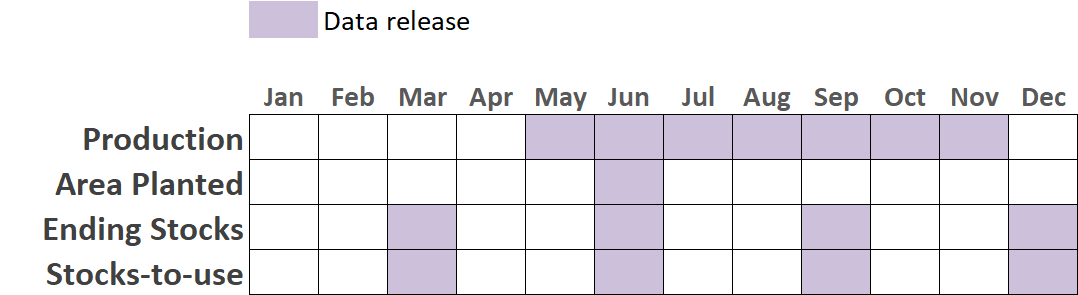
</div>


**Bloomberg** Bloomberg provides  historical times-series on crop production and planted acreage data. The strategy relies on monthly historical data between Jan-2009 and Feb-2022 for each crop in our universe. The key metrics imported were production, yield, ending stock, stocks-to-use ratio, and area harvested.

**USDA** The US Department of Agriculture publishes monthly reports(1) on crop production volumes and annual reports on total harvested land. These reports are relied on as the source of truth and used to validate data from Bloomberg.

**Other Sources** The National Weather Service collects monthly temperature and precipitations averages for each US state for the period Jan-2009 to Jan-2022. The strategy accounts for temperature and precipitations datapoints for the major crop producing states. Based on the USDA reports the strategy integrates meteorological datapoint for the US largest crop producers – i.e., Iowa, North Dakota, Kansas, Illinois, Minnesota, Nebraska, South Dakota, Missouri, and Indiana.

In [2]:
# Production Data (Source: BBG and USDA)
df_corn = pd.read_excel('USDA.xlsx', sheet_name = 'Corn').set_index('Date').sort_index()
df_wheat = pd.read_excel('USDA.xlsx', sheet_name = 'Wheat').set_index('Date').sort_index()
df_soybean = pd.read_excel('USDA.xlsx', sheet_name = 'Soybean').set_index('Date').sort_index()
df_dict = {'Corn': df_corn, 'Wheat': df_wheat, 'Soybean': df_soybean}
df_USDA = pd.concat(df_dict, axis = 1)

# US planted land (Source: USDA, Cornell)
df_us_land = pd.read_csv('US Arable Land.csv').set_index('Date')
df_us_land.index = pd.to_datetime(df_us_land.index)

# temperature and precipitation data
temperature = pd.read_excel('Average Temperature Per State.xlsx', sheet_name = 'Average')
temperature.set_index(temperature.columns[0], inplace = True)
precipitation = pd.read_excel('Average Precipitation Per State.xlsx', sheet_name = 'Average')
precipitation.set_index(precipitation.columns[0], inplace = True)

In [3]:
# index
df_index = pd.read_excel('Production Dates.xlsx', sheet_name = 'Sheet1').set_index('Unnamed: 0')

# get index
index = []
for month in df_index.columns:
    index+=list(df_index[month].values)
index = index[10:-5]
index.sort()
index.remove(index[58])

In [4]:
def usda_cleaning(df, index):
    '''
    cleaning the dataframes 
    '''
    df[df.pct_change()==0] = np.nan
    df.fillna(df.interpolate(method='linear'),inplace = True)
    df['DATE'] = index
    df.set_index('DATE', inplace = True)
    df.sort_index(inplace = True)

In [5]:
# df cleaning
usda_cleaning(df_corn, index)
usda_cleaning(df_wheat, index)
usda_cleaning(df_soybean, index)
usda_cleaning(df_USDA, index)

In [6]:
# temperature and precipitation cleaning
def temp_prep_cleaning(df, label):
    dates = pd.date_range(start='31-01-2009', end = '31-12-2022', freq = 'M')
    clean_df = pd.DataFrame(index = dates, columns = [label])
    temp_list = []
    for i in df.index:
        temp_list.extend(list(df.loc[i].values))
    clean_df[label] = temp_list
    clean_df = clean_df.loc[:'2022-01-31']
    return clean_df  

In [7]:
temperature = temp_prep_cleaning(temperature, 'temperature')
precipitation = temp_prep_cleaning(precipitation, 'precipitation')

Our securities universe is comprised of futures contracts on major US crops - i.e., corn, wheat, and soybean.

**QuandL** The Stevens Analytics Continuous Futures library provides a collection of long-term continuous price history for U.S. and international futures contracts traded on the CME. For all commodities in the universe, historical time-series data on front and back month contracts are considered.

In [8]:
# Commodities futures (Source: Quandl)
start, end = '2009-01-01', '2022-02-10'
dates_list = [str(i) for i in list(pd.date_range(start, end))]
dates = ','.join(dates_list)

# first contract
corn_futures_first = quandl.get_table('SCF/PRICES', date=dates, quandl_code='CME_C1_ON').drop('name', axis = 1).set_index('date')
soybean_futures_first = quandl.get_table('SCF/PRICES', date=dates, quandl_code='CME_S1_ON').drop('name', axis = 1).set_index('date')
wheat_futures_first = quandl.get_table('SCF/PRICES', date=dates, quandl_code='CME_W1_ON').drop('name', axis = 1).set_index('date')

# second contract
corn_futures_second = quandl.get_table('SCF/PRICES', date=dates, quandl_code='CME_C2_ON').drop('name', axis = 1).set_index('date')
soybean_futures_second = quandl.get_table('SCF/PRICES', date=dates, quandl_code='CME_S2_ON').drop('name', axis = 1).set_index('date')
wheat_futures_second = quandl.get_table('SCF/PRICES', date=dates, quandl_code='CME_W2_ON').drop('name', axis = 1).set_index('date')

Historical data for the selected benchmarks is imported from QUOTEMEDIA. 

In [9]:
# get price function
def get_price(myticker, start, end):
    '''
    Return stock price timeseries
    '''
    a = [str(i) for i in list(pd.date_range(start, end))]
    dates = ','.join(a)
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=myticker, date = dates).set_index('date').sort_index(axis=0)
    df.drop(columns=['ticker'], inplace = True)
    ticker = pd.DataFrame(columns = [myticker], index = df.index) 
    ticker[myticker] = df['adj_close']
    return ticker

In [10]:
# Benckmarks
tickers = ['SPY', 'DIA', 'DBA', 'RJA', 'CORN', 'WEAT', 'SOYB']
start =  df_corn.index[0]
end = df_corn.index[-1]
benchmark_df = pd.DataFrame(columns = tickers)
for i in tickers:
    benchmark_df[i] = get_price(i, start, end)[i]
# benchmark_df = benchmark_df.loc[index]
benchmark_df = benchmark_df.pct_change()
benchmark_df['Constructed'] = (benchmark_df[benchmark_df.columns[-4:-1]].sum(axis = 1))/3

In [11]:
benchmark_df = benchmark_df[['SPY', 'DIA','DBA', 'RJA', 'Constructed']][1:]

## 3. Agricultural Data  Initial Analysis
**A walk forward optimization is be used on the dataset to optimize parameters in the production forecast model. A minimum of 1 year is be used to train the model. The training set expands with time to incorporate more historical data, mimicking the filtration of knowledge with time. The trained model is used to predict the production for the next growing season.**

The chart below shows that the three chosen crops account for a large percentage of total planted acres for the entire analysis period. Additionally, it shows that the total planted area and its allocation between crops appears to be fairly stable over time.

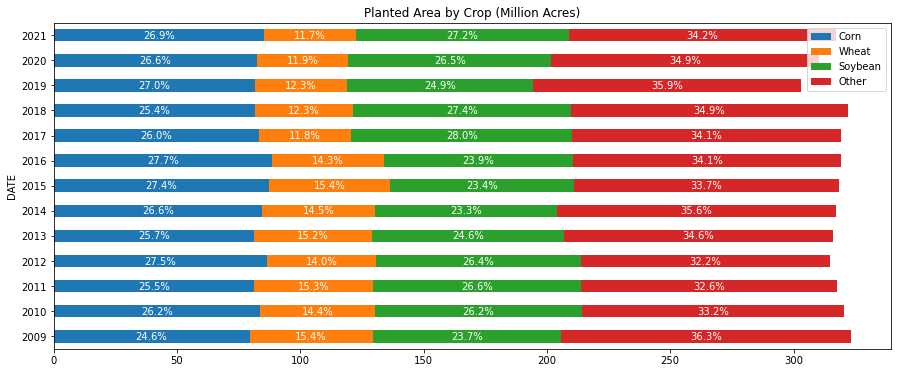

In [12]:
# Planted Area by Crop
df = pd.DataFrame(columns = ['Corn', 'Wheat', 'Soybean'])
df['Corn'] = df_corn['Area Harvested (1000 ACRES)']
df['Wheat'] = df_wheat['Area Harvested (1000 ACRES)']
df['Soybean'] = df_soybean['Area Harvested (1000 ACRES)']
df = df/1000
#df = df.loc[:'31-05-2016']
df = df.loc[:'2021-12-31']
df = df.resample('Y').last()
#df['Total'] = df_us_land.loc['2009':'2016', 'Arable Land (acres)'].values/10**6
df['Total'] = df_us_land.loc['2009':'2022', 'Principal Crops Area Planted (acres)'].values/10**6
df['Other'] = df['Total'] - df['Soybean'] - df['Corn'] - df['Wheat']
df.drop('Total', axis = 1, inplace = True)
df.index = df.index.year

df.plot(
  kind = 'barh', 
  stacked = True, 
  title = 'Planted Area by Crop (Million Acres)', figsize=(15, 6),
  mark_right = True)
  
df_total = df["Corn"] + df["Wheat"] + df["Soybean"] + df["Other"]
df_rel = df[df.columns[0:]].div(df_total, 0) * 100
  
for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df.iloc[:, 0:].cumsum(1)[n], 
                                         df[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center',
                 ha = 'center', 
                 color = 'white')

The below graph illustrates production of the three crops we have chosen over the years. In absolute values, production of corn is much higher. Please note that gray areas represent non-growth periods. In those non-growth periods, production and yield datapoints are not reported. This is why the time-series in the graphs below appear flat in those periods.

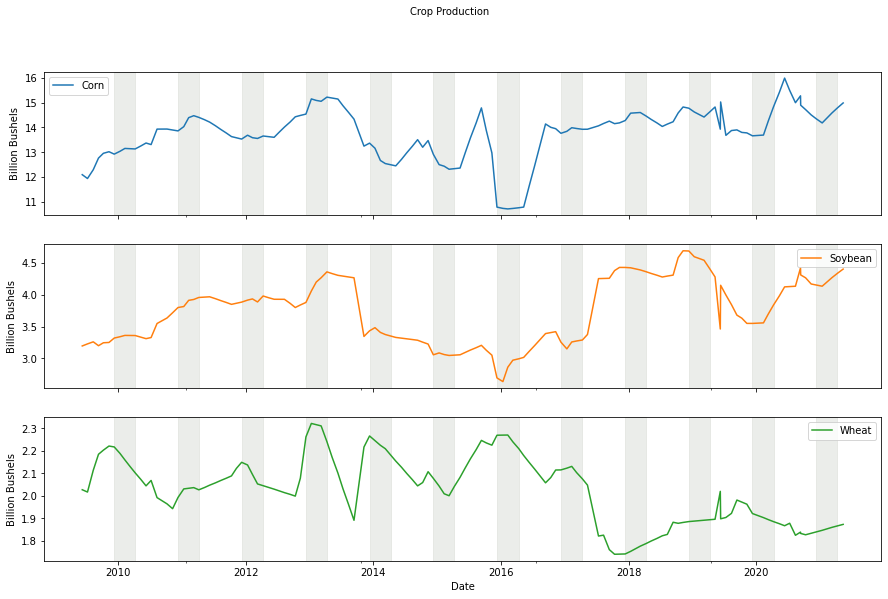

In [13]:
# Production Plot
plot_cols = ['Corn', 'Soybean','Wheat']
data = pd.DataFrame(columns = plot_cols)
#data['Corn'] = df_corn.loc[:'31-05-2016','Production (1000) BUSHELS']
data['Corn'] = df_corn.loc[:'31-05-2021','Production (1000) BUSHELS']
data['Soybean'] = df_soybean.loc[:'31-05-2021','Production (1000) BUSHELS']
data['Wheat'] = df_wheat.loc[:'31-05-2021','Production (1000) BUSHELS']
data = data / (10**6)

data['month'] = data.index
data['month'] = data['month'].dt.month
no_grow_beg_end = pd.DataFrame(columns = ['beg', 'end'])
beg = [i for i in data.index if data.loc[i, 'month']==12]
end = [i for i in data.index if data.loc[i, 'month']==4]
no_grow_beg_end['end'] = end
no_grow_beg_end['beg'] = beg


fig, axes = plt.subplots(3,1, figsize=(15,9), sharex=True)
data[plot_cols].plot(subplots=True, ax=axes)
axes[2].set_xlabel('Date')
# axes[0].title('Date')
for ax in axes:
    for i in range(len(no_grow_beg_end)):
        ax.axvspan(beg[i], end[i], color=sns.xkcd_rgb['light grey'], alpha=0.5)
        ax.set_ylabel('Billion Bushels')
fig.suptitle('Crop Production', size = 10) 
plt.show();

The relationship between production yields, temperature and precipitation is shown below

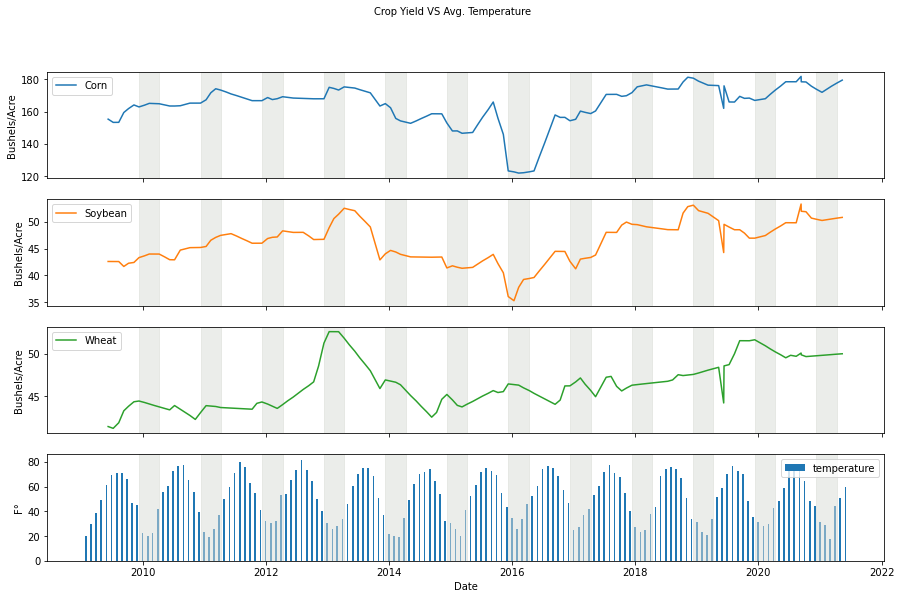

In [14]:
# yield plot temperature
data_yield = pd.DataFrame(columns = plot_cols)
data_yield['Corn'] = df_corn.loc[:'31-05-2021','Yield (BUSHELS/ACRE)']
data_yield['Soybean'] = df_soybean.loc[:'31-05-2021','Yield (BUSHELS/ACRE)']
data_yield['Wheat'] = df_wheat.loc[:'31-05-2021','Yield (BUSHELS/ACRE)']

fig, (ax1, ax2, ax3, ax4)= plt.subplots(4,1, figsize=(15,9), sharex=True)
axes = [ax1, ax2, ax3, ax4]


ax1.plot(data_yield['Corn'], color ='tab:blue', label = 'Corn')
ax1.legend()
ax1.set_ylabel('Bushels/Acre') 
ax2.plot(data_yield['Soybean'], color ='tab:orange', label = 'Soybean')
ax2.set_ylabel('Bushels/Acre')
ax2.legend()
ax3.plot(data_yield['Wheat'], color ='tab:green', label = 'Wheat')
ax3.set_ylabel('Bushels/Acre')
ax3.legend()

ax4.bar(temperature.loc[:'31-05-2021'].index,
        temperature.loc[:'31-05-2021','temperature'].values, width=10, label = 'temperature')
ax4.xaxis_date()
ax4.legend()
ax4.set_ylabel('F°')
ax4.set_xlabel('Date')

for ax in axes:
    for i in range(len(no_grow_beg_end)):
        gca = plt.gca()
        ax.axvspan(beg[i], end[i], color=sns.xkcd_rgb['light grey'], alpha=0.5)

fig.suptitle('Crop Yield VS Avg. Temperature', size = 10)
plt.show()

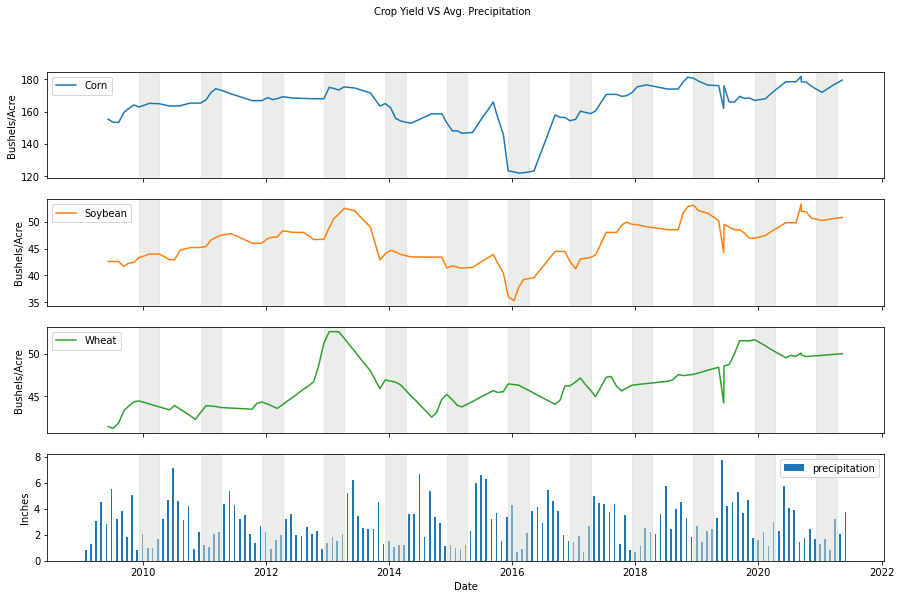

In [15]:
# yield plot precipitation
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4,1, figsize=(15,9), sharex=True)
axes = [ax1, ax2, ax3, ax4]


ax1.plot(data_yield['Corn'], color ='tab:blue', label = 'Corn')
ax1.legend()
ax1.set_ylabel('Bushels/Acre')
ax2.plot(data_yield['Soybean'], color ='tab:orange', label = 'Soybean')
ax2.set_ylabel('Bushels/Acre')
ax2.legend()
ax3.plot(data_yield['Wheat'], color ='tab:green', label = 'Wheat')
ax3.set_ylabel('Bushels/Acre')
ax3.legend()

ax4.bar(precipitation.loc[:'31-05-2021'].index,
        precipitation.loc[:'31-05-2021','precipitation'].values, width=10, label = 'precipitation')
ax4.xaxis_date()
ax4.legend()
ax4.set_ylabel('Inches')
ax4.set_xlabel('Date')

for ax in axes:
    for i in range(len(no_grow_beg_end)):
        gca = plt.gca()
        ax.axvspan(beg[i], end[i], color=sns.xkcd_rgb['light grey'], alpha=0.5)

fig.suptitle('Crop Yield VS Avg. Precipitation', size = 10)
plt.show()

## 4. Production Forecast Model
The production forecast model follows the following framework: 
1. Predict the total area planted in the United States based on historical total area planted data (Step a)
2. Predict the percentage of total area planted for each crop (Step b)
3. Predict the total area harvested for each crop using total area planted and percentage of total area planted (Step c)
4. Predict yield and production for each crop at the beginning of the growing season (Step d)

### a. Total Area Planted

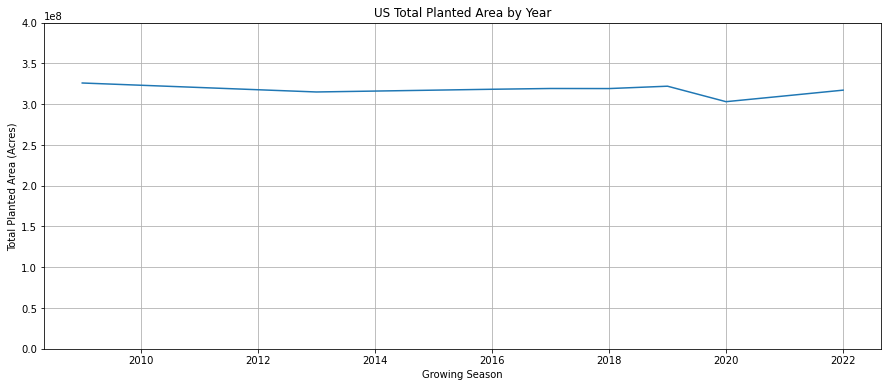

In [16]:
# total planted area plot
fig, ax = plt.subplots(figsize=(15,6))
ax.grid(True)
ax.plot(df_us_land.loc['2008':,'Principal Crops Area Planted (acres)'])
ax.set_ylim([0, 4e8])
ax.set_ylabel('Total Planted Area (Acres)')
ax.set_xlabel('Growing Season')
ax.set_title('US Total Planted Area by Year');

Starting with a prediction on the total area planted in the United States. The above graph shows that the total area planted has been very stable since 2009.

**As such, an exponential moving average from the previous 5 years is used to predict the total area planted in the current year.**

In [17]:
df_us_land['Area Planted Pred (acres)'] = df_us_land['Principal Crops Area Planted (acres)'].shift(1).ewm(span=5).mean()

In [18]:
# build a column of year
df_us_land['Year'] = df_us_land.index
df_us_land['Year'] = df_us_land['Year'].dt.year

###  b. Percentage of Total Area Planted by Crop
The second step is to predict the percentage of total area planted for each crop.  

The USDA data is presented in an unorthodox fasion - in that the data is a mix of forecast and actual numbers. Reconciling the time-series data to the actuals reported by the USDA for the prior growing seasons, the following months were used to determine actuals from the data:
- Area harvested for corn reported in January is the actual number for the growing season that just ended
- Area harvested for wheat reported in October is the actual number for the growing season that just ended
- Area harvested for soybean reported in Janaury is the actual number for the growing season that just ended

In [19]:
# build a data frame of area harvested
df_area_harvested = pd.DataFrame()
df_area_harvested['Corn (acres)'] = df_corn['Area Harvested (1000 ACRES)']
df_area_harvested['Wheat (acres)'] = df_wheat['Area Harvested (1000 ACRES)']
df_area_harvested['Soybean (acres)'] = df_soybean['Area Harvested (1000 ACRES)']
df_area_harvested = df_area_harvested*1000

In [20]:
# add columns of year and month
df_area_harvested['Year'] = df_area_harvested.index
df_area_harvested['Year'] = df_area_harvested['Year'].dt.year
df_area_harvested['Month'] = df_area_harvested.index
df_area_harvested['Month'] = df_area_harvested['Month'].dt.month

Using the months that have actual area harvested, the percentage of total area planted is calculated by crop. The model makes the assumption here that total area harvested is equal to the total area planted for each crop, but in reality, there is the risk of crop failure. According to USDA, in recent years, crops have failed on 2-3 percent of the acreage planted for harvest. This fact is considered immaterial and further excluded from the model.

In [21]:
# using Jan data for corn and soybean
df_area_harvested_annual = df_area_harvested[df_area_harvested['Month'] == 1].loc[:,['Corn (acres)', 'Soybean (acres)', 'Year']]
# subtract year by 1 because Jan numbers is for the previous year
df_area_harvested_annual['Year'] = df_area_harvested_annual['Year'] -1 
# set new index
df_area_harvested_annual = df_area_harvested_annual.set_index('Year')

# add wheat
temp = df_area_harvested[df_area_harvested['Month'] == 10].loc[:,['Wheat (acres)', 'Year']]
# combine with corn and soybean
df_area_harvested_annual = pd.concat([df_area_harvested_annual, temp.set_index('Year')], axis=1)

# forward fill NaN
df_area_harvested_annual = df_area_harvested_annual.fillna(method='ffill')

In [22]:
# calculate each crop's percentage of total area planted

# initialize columns
df_area_harvested_annual['Corn_percent'] = None
df_area_harvested_annual['Wheat_percent'] = None
df_area_harvested_annual['Soybean_percent'] = None

# build a dictionary of total area planted by year
area_planted_dict = {}

for area, year in df_us_land.loc['2009':,['Principal Crops Area Planted (acres)','Year']].values:
    area_planted_dict[year] = area
    
# calculate percentage of total area planted
for row in range(len(df_area_harvested_annual)):
    year = df_area_harvested_annual.index[row]
    area_planted = area_planted_dict[year]    
    
    df_area_harvested_annual['Corn_percent'].iloc[row] = (df_area_harvested_annual['Corn (acres)'].iloc[row])/area_planted
    df_area_harvested_annual['Wheat_percent'].iloc[row] = (df_area_harvested_annual['Wheat (acres)'].iloc[row])/area_planted
    df_area_harvested_annual['Soybean_percent'].iloc[row] = (df_area_harvested_annual['Soybean (acres)'].iloc[row])/area_planted

The percentage of total area planted for corn and soybean has increased since 2009. The percentage of total area planted for wheat has decreased since 2009.

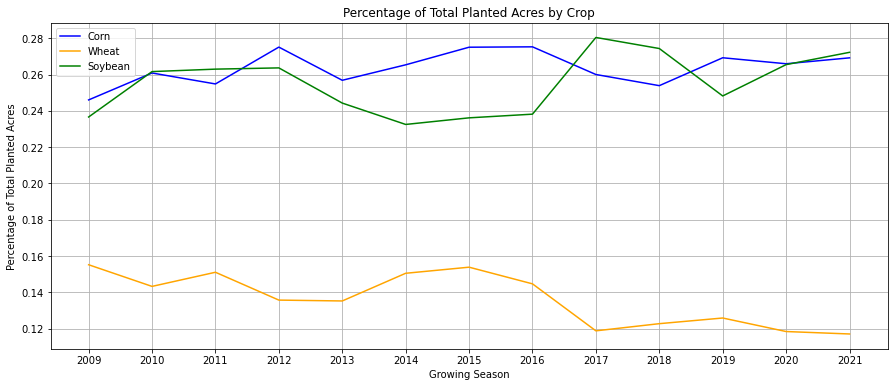

In [23]:
# plot
fig, ax = plt.subplots(figsize=(15,6))
ax.grid(True)
ax.plot(df_area_harvested_annual.loc[:,'Corn_percent'], label='Corn', color='blue')
ax.plot(df_area_harvested_annual.loc[:,'Wheat_percent'], label='Wheat', color='orange')
ax.plot(df_area_harvested_annual.loc[:,'Soybean_percent'], label='Soybean', color='green')
ax.set_xticks(np.arange(2009, 2022, 1));
plt.legend(fontsize = 10)
ax.set_ylabel('Percentage of Total Planted Acres')
ax.set_xlabel('Growing Season')
ax.set_title('Percentage of Total Planted Acres by Crop');

**Due to the drift in the percentage of total planted area, a shorter exponential moving average (previous 3 growing seasons) is used to predict the percentage of total area planted for each crop.**

In [24]:
df_area_harvested_annual['Corn_percent_pred'] = df_area_harvested_annual['Corn_percent'].shift(1).ewm(span=3).mean()
df_area_harvested_annual['Wheat_percent_pred'] = df_area_harvested_annual['Wheat_percent'].shift(1).ewm(span=3).mean()
df_area_harvested_annual['Soybean_percent_pred'] = df_area_harvested_annual['Soybean_percent'].shift(1).ewm(span=3).mean()

### C. Total Area Planted by Crop
Step 3 is to determine the total area planted by crop. The predicted area planted for each crop is determined from the product of predicted total area planted and predicted precentage of total area planted for each crop.

In [25]:
# predict each crop's percentage of total area planted for next season

# initialize columns
df_area_harvested_annual['Corn_pred (acres)'] = None
df_area_harvested_annual['Wheat_pred (acres)'] = None
df_area_harvested_annual['Soybean_pred (acres)'] = None

# predicted total land * crop percentage
df_area_harvested_annual['Corn_pred (acres)'] = df_us_land.set_index('Year').loc['2009':, 'Area Planted Pred (acres)'] * df_area_harvested_annual['Corn_percent_pred']
df_area_harvested_annual['Wheat_pred (acres)'] = df_us_land.set_index('Year').loc['2009':, 'Area Planted Pred (acres)'] * df_area_harvested_annual['Wheat_percent_pred']
df_area_harvested_annual['Soybean_pred (acres)'] = df_us_land.set_index('Year').loc['2009':, 'Area Planted Pred (acres)'] * df_area_harvested_annual['Soybean_percent_pred']

The comparison of predicted total area planted for each crop to actual area planted shows encouraging results.

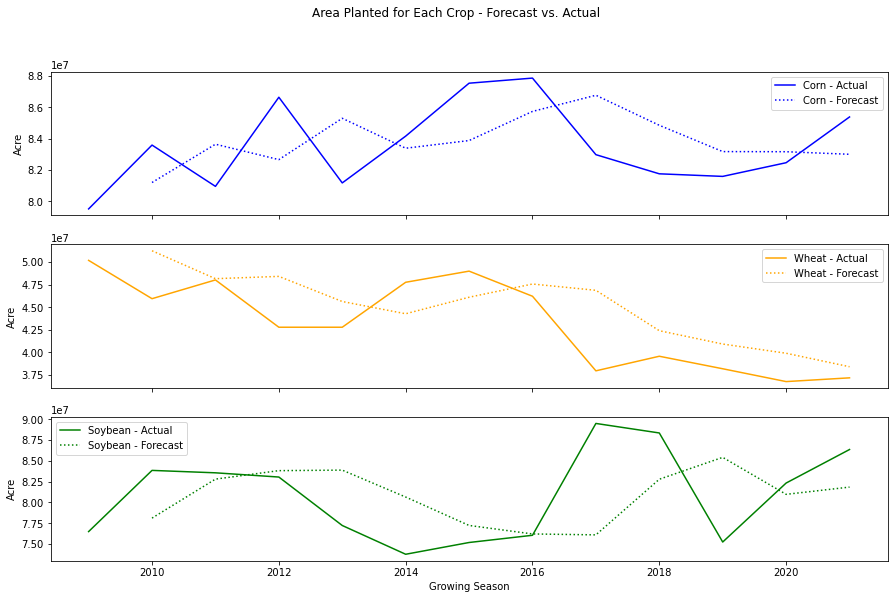

In [26]:
# yield plot precipitation
fig, (ax1, ax2, ax3)= plt.subplots(3,1, figsize=(15,9), sharex=True)
axes = [ax1, ax2, ax3]

ax1.plot(df_area_harvested_annual['Corn (acres)'], color ='blue', label = 'Corn - Actual')
ax1.plot(df_area_harvested_annual['Corn_pred (acres)'], color ='blue', linestyle = ':', label = 'Corn - Forecast')
ax1.legend()
ax1.set_ylabel('Acre')

ax2.plot(df_area_harvested_annual['Wheat (acres)'], color ='orange', label = 'Wheat - Actual')
ax2.plot(df_area_harvested_annual['Wheat_pred (acres)'], color ='orange', linestyle = ':', label = 'Wheat - Forecast')
ax2.legend()
ax2.set_ylabel('Acre')

ax3.plot(df_area_harvested_annual['Soybean (acres)'], color ='green', label = 'Soybean - Actual')
ax3.plot(df_area_harvested_annual['Soybean_pred (acres)'], color ='green', linestyle = ':', label = 'Soybean - Forecast')
ax3.legend()
ax3.set_ylabel('Acre')
ax3.set_xlabel('Growing Season')

fig.suptitle('Area Planted for Each Crop - Forecast vs. Actual')
plt.show()

### D. Predicting Yield & Production at the Beginning of Growing Season
The final step is to examine the yields. Another irregularity in the USDA data is that the yield is carried over to the next month if there is no new information. The repeating data points are removed to reduce their effects on our production forecasting models. 

In [27]:
# importing USDA data without duplicated data points
df_corn_filtered = pd.read_excel('USDA_Filtered.xlsx', sheet_name = 'Corn').set_index('Date').sort_index()
df_wheat_filtered = pd.read_excel('USDA_Filtered.xlsx', sheet_name = 'Wheat').set_index('Date').sort_index()
df_soybean_filtered = pd.read_excel('USDA_Filtered.xlsx', sheet_name = 'Soybean').set_index('Date').sort_index()

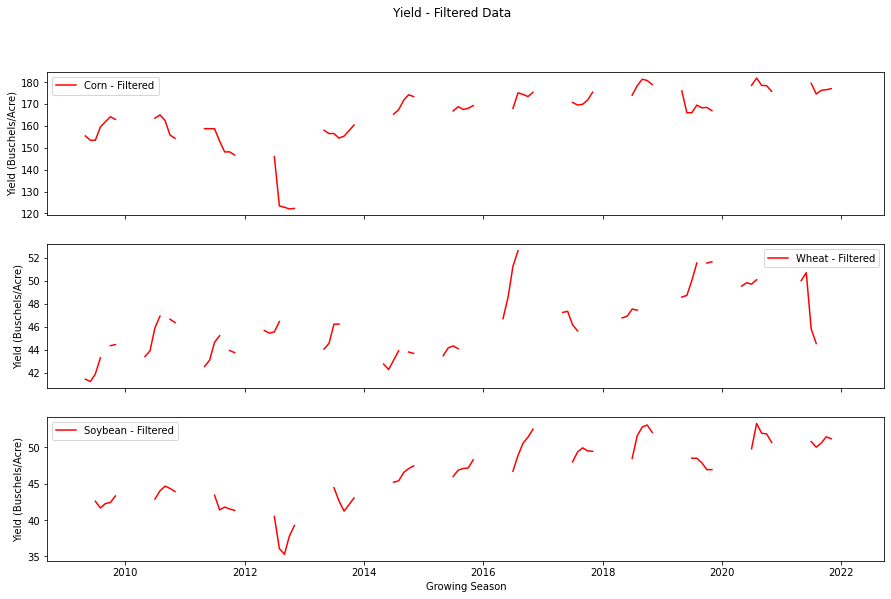

In [28]:
# yield plot precipitation
fig, (ax1, ax2, ax3)= plt.subplots(3,1, figsize=(15,9), sharex=True)
axes = [ax1, ax2, ax3]

#ax1.plot(df_corn.loc[:,'Yield (BUSHELS/ACRE)'], label = 'Corn - Unfiltered')
ax1.plot(df_corn_filtered.loc[:,'Yield (BUSHELS/ACRE)'], color ='red', label = 'Corn - Filtered')
ax1.legend()
ax1.set_ylabel('Yield (Buschels/Acre)')

#ax2.plot(df_wheat.loc[:,'Yield (BUSHELS/ACRE)'], label = 'Wheat - Unfiltered')
ax2.plot(df_wheat_filtered.loc[:,'Yield (BUSHELS/ACRE)'], color ='red', label = 'Wheat - Filtered')
ax2.legend()
ax2.set_ylabel('Yield (Buschels/Acre)')

#ax3.plot(df_soybean.loc[:,'Yield (BUSHELS/ACRE)'], label = 'Soybean - Unfiltered')
ax3.plot(df_soybean_filtered.loc[:,'Yield (BUSHELS/ACRE)'], color ='red', label = 'Soybean - Filtered')
ax3.legend()
ax3.set_ylabel('Yield (Buschels/Acre)')
ax3.set_xlabel('Growing Season')

fig.suptitle('Yield - Filtered Data')
plt.show()

The absence of yield updates during certain months of the year can be used to infer growing season. **All three crops are typically grown from May to November.**

###### Analysis of trend of "Yield vs Time" during each growing season

In [29]:
df_yield = pd.DataFrame()
df_yield['Corn'] = df_corn_filtered['Yield (BUSHELS/ACRE)']
df_yield['Wheat'] = df_wheat_filtered['Yield (BUSHELS/ACRE)']
df_yield['Soybean'] = df_soybean_filtered['Yield (BUSHELS/ACRE)']

# generate year and month columns
df_yield['Year'] = df_yield.index
df_yield['Year'] = df_yield['Year'].dt.year
df_yield['Month'] = df_yield.index
df_yield['Month'] = df_yield['Month'].dt.month

In [30]:
def graph_yield(df, label):
    
    df_pivot = pd.pivot_table(df, index=df.index.month, columns=df.index.year, values=label, aggfunc=np.sum)
    
    fig, ax = plt.subplots(figsize=(15,6))
    ax.grid(True)
    
    for year in df_pivot.columns:       
        ax.scatter(df_pivot.loc[5:11].index, df_pivot.loc[5:11, year])
    
    if label == 'Corn':
        ax.set_ylim([120, 190])
    else:            
        ax.set_ylim([(df_pivot.quantile(0.23).max()//10)*10-5, (df_pivot.max().max()//10)*10+5])
    
    ax.set_ylabel('Yield (Buschels/Acre)')
    ax.set_xlabel('Month')
    ax.set_title(label + ' Yield By Month' )

    plt.show()

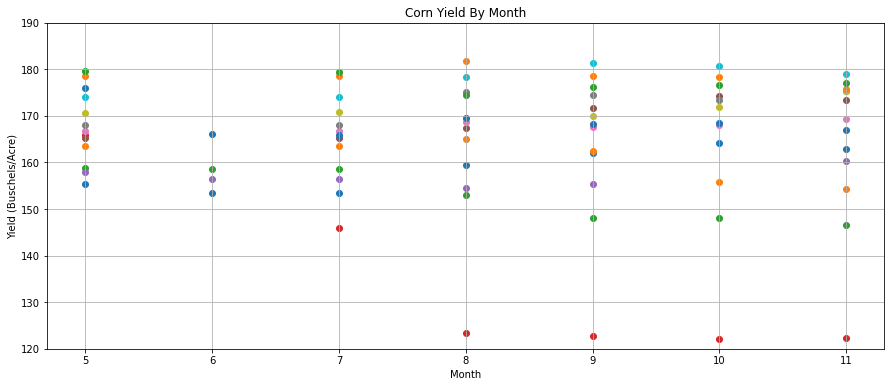

In [31]:
graph_yield(df_yield, 'Corn')

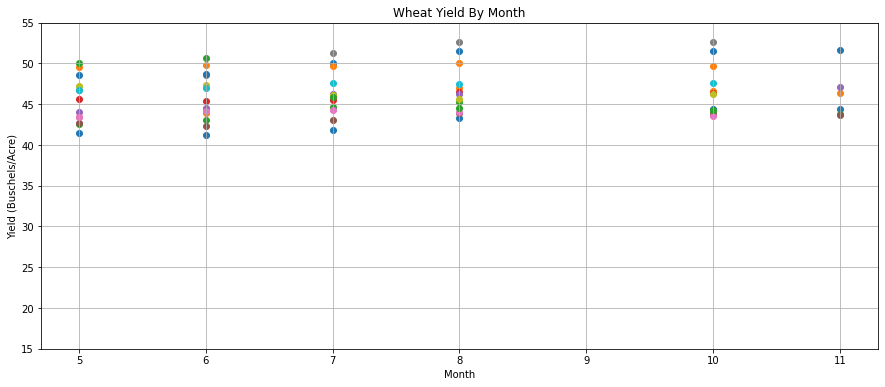

In [32]:
graph_yield(df_yield, 'Wheat')

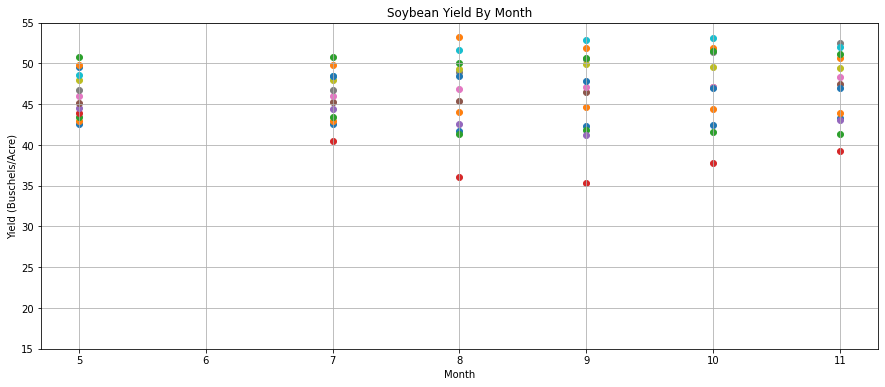

In [33]:
graph_yield(df_yield, 'Soybean')

From the above graphs, it is conclude that yield during the growing season is relatively constant and the noise is likely due to factors such as precipitation and temperature. It was observed that lower yield number in 2012 (red dots in the above plots) coincided with less precipitation.

To determine the effect of precipitation and temperature, yield is regressed against the two factors using data points from recent months. 

In [34]:
# change index on precipitation from end of month to beginning
precipitation['Date'] = precipitation.index - pd.offsets.MonthBegin(1)
precipitation = precipitation.set_index('Date')
precipitation = precipitation.rename(columns={'precipitation':'Precipitation'})

In [35]:
# change index on temperature from end of month to beginning
temperature['Date'] = temperature.index - pd.offsets.MonthBegin(1)
temperature = temperature.set_index('Date')
temperature = temperature.rename(columns={'temperature':'Temperature'})

In [36]:
# merge precipitation, temperature with yield
df_yield = pd.merge(df_yield, precipitation, left_index=True, right_index=True)
df_yield = pd.merge(df_yield, temperature, left_index=True, right_index=True)

In [37]:
df_yield['Precipitation'] = df_yield['Precipitation'].astype('float')
df_yield['Temperature'] = df_yield['Temperature'].astype('float')

In [38]:
# shift precipitation and temperature
df_yield['Precipitation_prev1'] = df_yield['Precipitation'].shift(1)
df_yield['Precipitation_prev2'] = df_yield['Precipitation'].shift(2)
df_yield['Precipitation_prev3'] = df_yield['Precipitation'].shift(3)
df_yield['Temperature_prev1'] = df_yield['Temperature'].shift(1)
df_yield['Temperature_prev2'] = df_yield['Temperature'].shift(2)
df_yield['Temperature_prev3'] = df_yield['Temperature'].shift(3)

Examining the correlations between datapoints for the prior 3 months precipitation (**p1,p2,p3**) and temperature (**t1,t2,t3**), the following observations were made:

- Inter-month precipitation and temperature was highly correlated, ranging from 0.6013 to 0.6044. 
- The correlations between **p3** and **t2** and **p2** and **t1** were also significant, at 0.6440 and 0.6466, respectively. 
- Temperature has a high correlation with itself, with **t1** to **t2** and **t2** to **t3** scoring at 0.8287 and 0.8295, respectively. A possible explanation is this is autocorrelation. 
- Precipitation was not highly correlated with itself, with figures ranging from 0.2653 to 0.4186. 

Thus, to avoid multicollinearity, temperature is exlcuded from the regression.

In [39]:
df_yield.loc[:,['Precipitation_prev1', 'Precipitation_prev2', 'Precipitation_prev3',
                'Temperature_prev1', 'Temperature_prev2', 'Temperature_prev3']].corr().round(4)

,Precipitation_prev1,Precipitation_prev2,Precipitation_prev3,Temperature_prev1,Temperature_prev2,Temperature_prev3
Precipitation_prev1,1.0000,0.4186,0.2653,0.6044,0.4046,0.0712
Precipitation_prev2,0.4186,1.0000,0.4140,0.6466,0.6021,0.4027
Precipitation_prev3,0.2653,0.4140,1.0000,0.5264,0.6440,0.6013
Temperature_prev1,0.6044,0.6466,0.5264,1.0000,0.8297,0.4660
Temperature_prev2,0.4046,0.6021,0.6440,0.8297,1.0000,0.8295
Temperature_prev3,0.0712,0.4027,0.6013,0.4660,0.8295,1.0000


In [40]:
def regression(df_y, df_x, intercept=True, annual_fac=12, return_reg=False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        y = df_y

        if intercept == True:            
            X = sm.add_constant(df_x)
        else:
            X = df_x

        results = sm.OLS(y, X.astype(float), missing='drop').fit()    
        reg_df = results.params.to_frame('Regression Parameters')
        reg_df.loc['r-squared'] = results.rsquared

        if intercept == True:
            reg_df.loc['const'] *= annual_fac

        if return_reg == False:
            return reg_df
        else:     
            return results

Regression on precipitation in the previous three months.

In [41]:
# run regressions
growing_months = [5,6,7,8,9,10,11]
# temp denotes the subset of the dataframe in the growing month periods
temp = df_yield[df_yield['Month'].isin(growing_months)]
precipitation_reg = regression(temp['Corn'], 
                               temp.loc[:,['Precipitation_prev1','Precipitation_prev2', 'Precipitation_prev3']], 
                               intercept=True, annual_fac=1, return_reg=False).rename(columns={'Regression Parameters':'Corn'})
precipitation_reg = pd.concat([precipitation_reg, regression(temp['Wheat'], 
                               temp.loc[:,['Precipitation_prev1','Precipitation_prev2', 'Precipitation_prev3']], 
                               intercept=True, annual_fac=1, return_reg=False)], axis=1).rename(columns={'Regression Parameters':'Wheat'})
precipitation_reg = pd.concat([precipitation_reg, regression(temp['Soybean'], 
                               temp.loc[:,['Precipitation_prev1','Precipitation_prev2', 'Precipitation_prev3']], 
                               intercept=True, annual_fac=1, return_reg=False)], axis=1).rename(columns={'Regression Parameters':'Soybean'})

precipitation_reg

,Corn,Wheat,Soybean
const,155.828583,44.805107,44.156200
Precipitation_prev1,1.308000,0.077933,0.244117
Precipitation_prev2,1.051308,-0.040495,0.327285
Precipitation_prev3,0.278701,0.473286,0.095965
r-squared,0.047091,0.070532,0.030529


**The $R^2$ values are quite small for these regressions, however the $\beta_i$ is still useful in adjusting the yield. It is interesting to observe a negative $\beta$ for precipitation. This is likely due to correlation within the precipitation data.**

Yield is predicted by determining the average annual yield from prior years and applying an exponential moving average to the previous 3 years. This is the baseline for the current growing season. During the growing season this annual baseline is adjusted with precipitation $\beta$s using precipitation data available to that point in time. 

As the dataset starts in 2009, 2010 will be the first year of predictions. 

In [42]:
df_yield['Corn_pred'] = np.nan
df_yield['Wheat_pred'] = np.nan
df_yield['Soybean_pred'] = np.nan

In [43]:
def yield_forecast(df_yield, label, start_year):
    
    df = df_yield.copy()

    # define growing months
    growing_months = [5,6,7,8,9,10,11]
    # subset df to only the growing months
    df_growing = df[df['Month'].isin(growing_months)]
    
    # column names dict
    col_names = {'Corn':'Corn_pred', 'Wheat':'Wheat_pred', 'Soybean':'Soybean_pred'}

    # build a pivot table
    df_yield_pivot = pd.pivot_table(df, index=df.index.month, columns=df.index.year, values=label, aggfunc=np.sum).T
    # replace 0 with nan
    df_yield_pivot = df_yield_pivot.replace(0, np.NaN)
    # find average of each year
    df_yield_pivot['ave'] = df_yield_pivot.loc[:,[5,6,7,8,9,10,11]].mean(axis=1)
    # EMA of previous 5 years
    df_yield_pivot['ew_ave'] = df_yield_pivot['ave'].shift(1).ewm(span=3).mean()

    # loop through df
    for i, row in df.iterrows():
        # only run forecast if it is greater than or equal to the start year and the month is a growing month
        if (row.Year >= start_year) and (row.Month in (growing_months)):
            # baseline is from EMA of previous 5 years
            baseline_yield = df_yield_pivot.loc[row.Year, ['ew_ave']]
            # define x and y for running regression
            y = df_growing.loc[:i, label]            
            x = df_growing.loc[:i, ['Precipitation_prev1','Precipitation_prev2', 'Precipitation_prev3']]

            # run regression on precipitation and get betas
            precipitation_betas = regression(y, x, intercept=True, annual_fac=1, return_reg=True).params[1:]

            # adjust yield with precipitation
            adj_yield = baseline_yield + df.loc[i, ['Precipitation_prev1','Precipitation_prev2', 'Precipitation_prev3']] @ precipitation_betas
            
            # save predicted yield
            df.loc[i, col_names[label]] = adj_yield[0]
    
    return df         

In [44]:
df_yield = yield_forecast(df_yield, 'Corn', 2010)
df_yield = yield_forecast(df_yield, 'Wheat', 2010)
df_yield = yield_forecast(df_yield, 'Soybean', 2010)

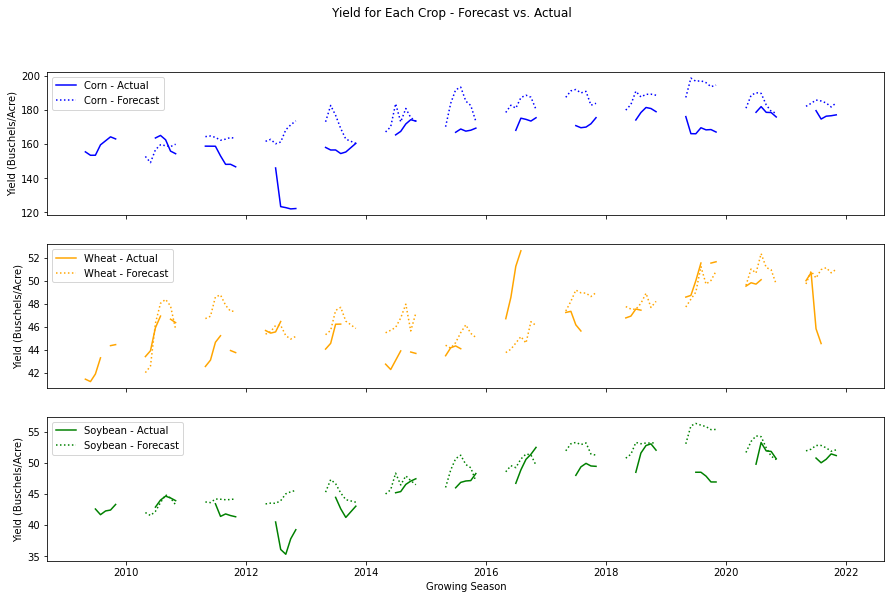

In [45]:
# yield plot 
fig, (ax1, ax2, ax3)= plt.subplots(3,1, figsize=(15,9), sharex=True)
axes = [ax1, ax2, ax3]

ax1.plot(df_yield['Corn'], color ='blue', label = 'Corn - Actual')
ax1.plot(df_yield['Corn_pred'], color ='blue', linestyle = ':', label = 'Corn - Forecast')
ax1.legend()
ax1.set_ylabel('Yield (Buschels/Acre)')

ax2.plot(df_yield['Wheat'], color ='orange', label = 'Wheat - Actual')
ax2.plot(df_yield['Wheat_pred'], color ='orange', linestyle = ':', label = 'Wheat - Forecast')
ax2.legend()
ax2.set_ylabel('Yield (Buschels/Acre)')

ax3.plot(df_yield['Soybean'], color ='green', label = 'Soybean - Actual')
ax3.plot(df_yield['Soybean_pred'], color ='green', linestyle = ':', label = 'Soybean - Forecast')
ax3.legend()
ax3.set_ylabel('Yield (Buschels/Acre)')

ax3.set_xlabel('Growing Season')

fig.suptitle('Yield for Each Crop - Forecast vs. Actual')
plt.show()

The total production for a given crop is the product of predicted yield multiplied by precidict land planted.

In [46]:
# df_prod
df_prod = pd.DataFrame()
df_prod['Corn_act'] = df_corn_filtered['Production (1000) BUSHELS'] * 1000
df_prod['Wheat_act'] = df_wheat_filtered['Production (1000) BUSHELS'] * 1000
df_prod['Soybean_act'] = df_soybean_filtered['Production (1000) BUSHELS'] * 1000
df_prod['Corn_yield_pred'] = df_yield['Corn_pred'] 
df_prod['Wheat_yield_pred'] = df_yield['Wheat_pred'] 
df_prod['Soybean_yield_pred'] = df_yield['Soybean_pred'] 
df_prod['Year'] = df_yield['Year'] 
df_prod['Month'] = df_yield['Month'] 

df_prod['Corn_pred'] = np.nan
df_prod['Wheat_pred'] = np.nan
df_prod['Soybean_pred'] =np.nan

In [47]:
def prod_forecast(df_prod, df_area_harvested_annual, label, start_year):
    # to be deleted
    #label = 'Corn'
    #start_year = 2010

    df = df_prod.copy()
    df_area = df_area_harvested_annual.copy()

    # define growing months
    growing_months = [5,6,7,8,9,10,11]
        
    # column names dict
    col_names = {'Corn':['Corn_pred', 'Corn_yield_pred', 'Corn_pred (acres)'], 
                 'Wheat':['Wheat_pred', 'Wheat_yield_pred', 'Wheat_pred (acres)'], 
                 'Soybean':['Soybean_pred', 'Soybean_yield_pred', 'Soybean_pred (acres)']}

    # loop through df
    for i, row in df.iterrows():
        # only run forecast if it is greater than or equal to the start year and the month is a growing month
        if (row.Year >= start_year) and (row.Month in (growing_months)):
            
            # save predicted prod
            df.loc[i, col_names[label][0]] = df.loc[i, col_names[label][1]] * df_area.loc[row.Year, col_names[label][2]]
    
    return df

In [48]:
# df_prod
df_prod = prod_forecast(df_prod, df_area_harvested_annual, 'Corn', 2010)
df_prod = prod_forecast(df_prod, df_area_harvested_annual, 'Wheat', 2010)
df_prod = prod_forecast(df_prod, df_area_harvested_annual, 'Soybean', 2010)

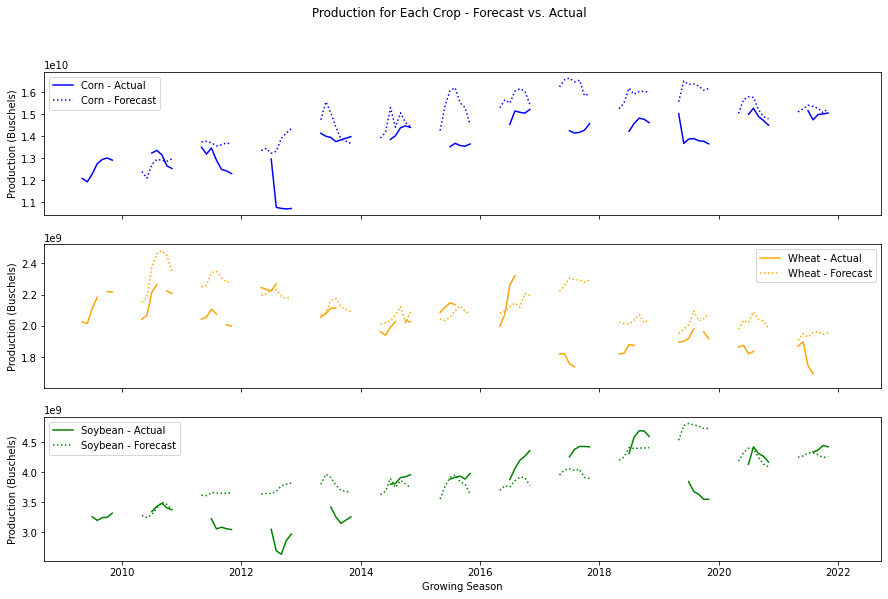

In [49]:
# yield plot 
fig, (ax1, ax2, ax3)= plt.subplots(3,1, figsize=(15,9), sharex=True)
axes = [ax1, ax2, ax3]

ax1.plot(df_prod['Corn_act'], color ='blue', label = 'Corn - Actual')
ax1.plot(df_prod['Corn_pred'], color ='blue', linestyle = ':', label = 'Corn - Forecast')
ax1.legend()
ax1.set_ylabel('Production (Buschels)')

ax2.plot(df_prod['Wheat_act'], color ='orange', label = 'Wheat - Actual')
ax2.plot(df_prod['Wheat_pred'], color ='orange', linestyle = ':', label = 'Wheat - Forecast')
ax2.legend()
ax2.set_ylabel('Production (Buschels)')

ax3.plot(df_prod['Soybean_act'], color ='green', label = 'Soybean - Actual')
ax3.plot(df_prod['Soybean_pred'], color ='green', linestyle = ':', label = 'Soybean - Forecast')
ax3.legend()
ax3.set_ylabel('Production (Buschels)')

ax3.set_xlabel('Growing Season')

fig.suptitle('Production for Each Crop - Forecast vs. Actual')
plt.show()

The production forecasts are for the growing seasons, however, note that trading is done on a year-around basis. As supply is halted in the non-growing months, supply (LTM) is assumed to be equal to the last available number. This is adjusted as actual USDA numbers are reported.

In [50]:
# df_prod_forecast
df_prod_forecast = pd.DataFrame(columns = ['Corn','Soybean','Wheat'], index = df_corn.index)
df_prod_forecast['Corn'] = df_prod['Corn_pred'].values
df_prod_forecast['Soybean'] = df_prod['Soybean_pred'].values
df_prod_forecast['Wheat'] = df_prod['Wheat_pred'].values

# actual value to fill
df_prod_forecast['Corn_act'] = df_prod['Corn_act'].fillna(method = 'ffill').values
df_prod_forecast['Soybean_act'] = df_prod['Soybean_act'].fillna(method = 'ffill').values
df_prod_forecast['Wheat_act'] = df_prod['Wheat_act'].fillna(method = 'ffill').values

# fillna
df_prod_forecast['Corn'].fillna(df_prod_forecast['Corn_act'], inplace = True)
df_prod_forecast['Soybean'].fillna(df_prod_forecast['Soybean_act'], inplace = True)
df_prod_forecast['Wheat'].fillna(df_prod_forecast['Wheat_act'], inplace = True)

# Dropping actual columns
df_prod_forecast.drop(['Corn_act', 'Soybean_act', 'Wheat_act'], axis = 1, inplace = True)

## 5. Demand Forecasting

**Thesis:**
Demand for crops is inelastic and consumption fluctuations are due to shocks in the supply. 

The thesis above is explored from a statistical perspective in order to develop a reliable forecast for crop demand.

Quantity consumed is defined as the difference in ending stocks between two consecutive periods plus production volumes in the same period. Beacuse productiion data is reported on a LTM basis - i.e. the numbers refer to the total production of the last 12 months - estimated figures for quantity consumed are also representative of the last 12 months.

In [51]:
df_consumption = pd.DataFrame(columns = ['Corn','Soybean','Wheat'], index = df_corn.index)
consumption_f = lambda df: df['Production (1000) BUSHELS']+\
                df['Ending Stocks (1000) BUSHELS'].shift(1)-df['Ending Stocks (1000) BUSHELS']
df_consumption['Corn'] = consumption_f(df_corn)
df_consumption['Soybean'] = consumption_f(df_soybean)
df_consumption['Wheat'] = consumption_f(df_wheat)
df_consumption.sort_index(inplace = True)

In [52]:
df_production = pd.DataFrame(columns = ['Corn','Soybean','Wheat'], index = df_corn.index)
production_f = lambda df: df['Production (1000) BUSHELS']
df_production['Corn'] = production_f(df_corn)
df_production['Soybean'] = production_f(df_soybean)
df_production['Wheat'] = production_f(df_wheat)

Explore the relationship between quantity consumed and market equilibrium prices by considering the front month futures contracts settling price as the price level.

In [53]:
# df_prices 
prices_index = [i for i in index if i in corn_futures_first.index]
df_prices = pd.DataFrame()
df_prices['Corn'] = corn_futures_first.loc[prices_index, 'settle']
df_prices['Soybean'] = soybean_futures_first.loc[prices_index, 'settle']
df_prices['Wheat'] = wheat_futures_first.loc[prices_index, 'settle']

# df_prices2
df_prices2 = pd.DataFrame()
df_prices2['Corn'] = corn_futures_second.loc[prices_index, 'settle']
df_prices2['Soybean'] = soybean_futures_second.loc[prices_index, 'settle']
df_prices2['Wheat'] = wheat_futures_second.loc[prices_index, 'settle']


df_prices.sort_index(inplace = True)

In [54]:
def plot_consumption_price_level(df_consumption, df_prices, label):
    '''
    Shows the plot of consumption volumes and the price level evolution
    '''
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,6), sharex=True)
    ax1.plot((df_consumption/10e6).loc[df_prices.index,label], color ='tab:blue', label = label)
    ax1.legend()
    ax1.set_ylabel('LTM Conumption (Millions Bushels)')
    
    ax2.plot(np.log(df_prices.loc[:,label]), label = 'Price', color = 'tab:orange')
    ax2.set_ylabel('Log Price Level ($USD)')
    ax2.legend()
    ax2.set_xlabel('Date')
    fig.suptitle(label, size = 10)
    plt.show();

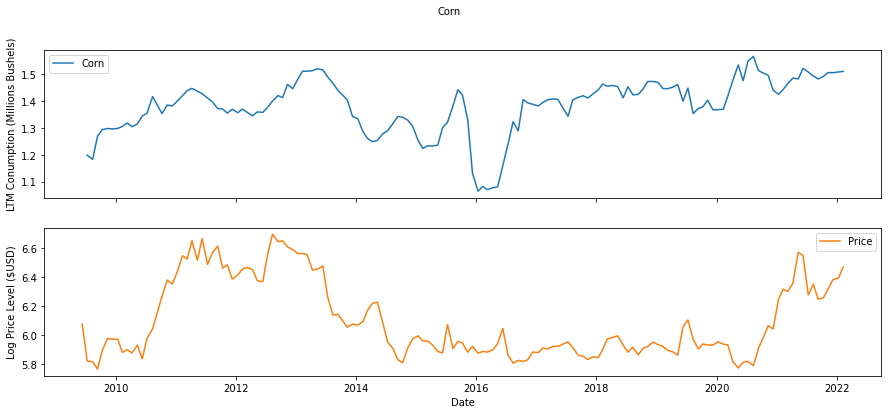

In [55]:
plot_consumption_price_level(df_consumption, df_prices, 'Corn')

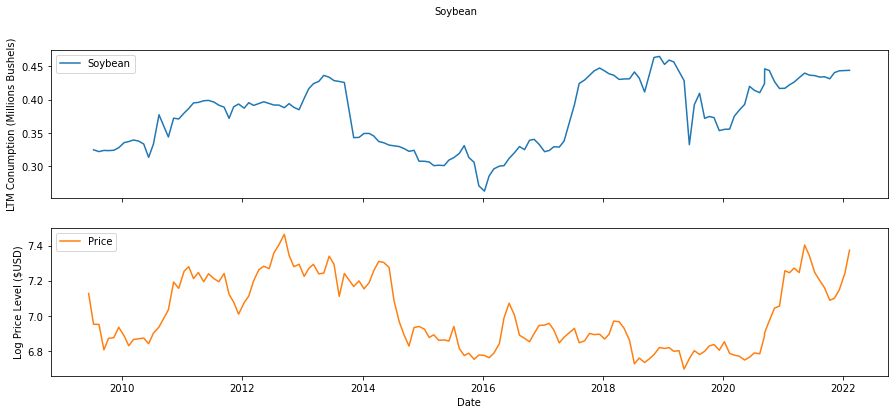

In [56]:
plot_consumption_price_level(df_consumption, df_prices, 'Soybean')

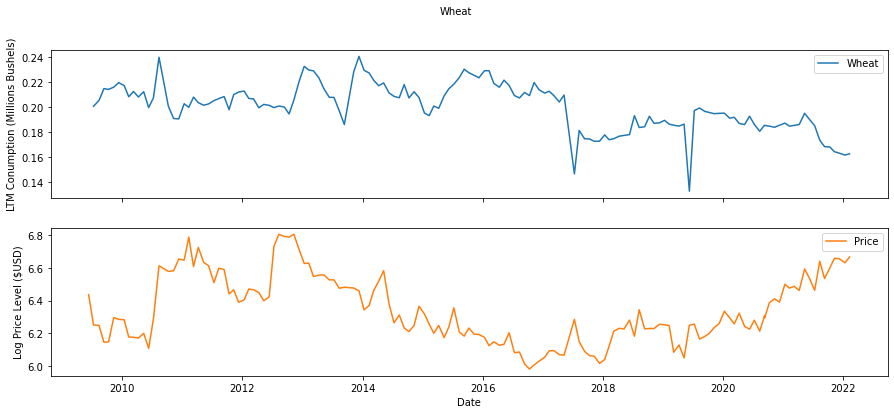

In [57]:
plot_consumption_price_level(df_consumption, df_prices, 'Wheat')

The above graphs show some degree of correlation between the price level and the consumption level which may indicate inelasticity. This is tested below

In [58]:
def demand_elasticity_model(df_consumption, df_prices, label, print_summary = False, plots = False,
                            RLS_plots = False):
    
    df = pd.DataFrame(columns = ['Quantity', 'Price'], index = df_prices.index)
    df['Quantity'] = df_consumption[label]/10e6
    df['Price'] = np.log(df_prices[label])
    
    # Regression Analysis
    
    # initial OLS analysis
    model = ols("Quantity ~ Price", data=df).fit()
    if print_summary:
        print(model.summary())
        
    titlestring = label+' Consumption Regression Analysis'
    
    # OLS Plots
    fig = plt.figure(figsize=(12,4), tight_layout= True)
    fig = sm.graphics.plot_partregress_grid(model, fig=fig)
    fig.suptitle(titlestring, size = 15)
    
    # Component-Component plus Residual (CCPR) Plots
    fig = plt.figure(figsize=(12, 8))
    fig = sm.graphics.plot_ccpr_grid(model, fig=fig)
    
    if plots:
        # Regression Plots
        fig = plt.figure(figsize=(12,8))
        fig = sm.graphics.plot_regress_exog(model, 'Price', fig=fig)
    
    # Recursive Least Square (RLS)
    # RLS filter to investigate parameter instability
    
    endog = df['Quantity']
    exog = sm.add_constant(df['Price'])
    mod = sm.RecursiveLS(endog, exog)
    res = mod.fit()
    if print_summary:
        print(res.summary())
    
    if RLS_plots:
        # We  generate the recursively estimated coefficients plot on variables
        res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

        # For convenience, we visually check for parameter stability using the plot_cusum function
        fig2 = res.plot_cusum(figsize=(15,5))
        fig2.suptitle('CUSUM Plot', size = 10)

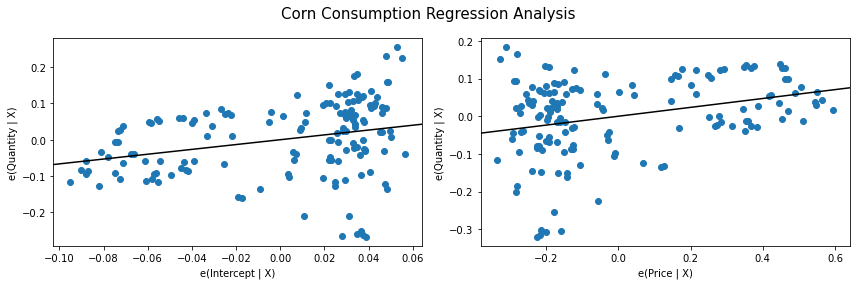

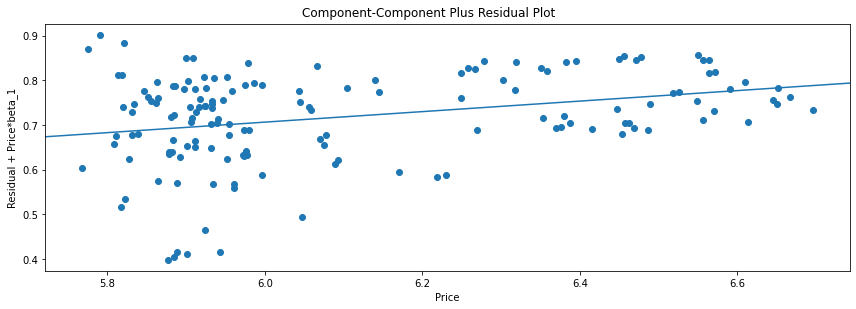

In [59]:
demand_elasticity_model(df_consumption, df_prices, 'Corn')

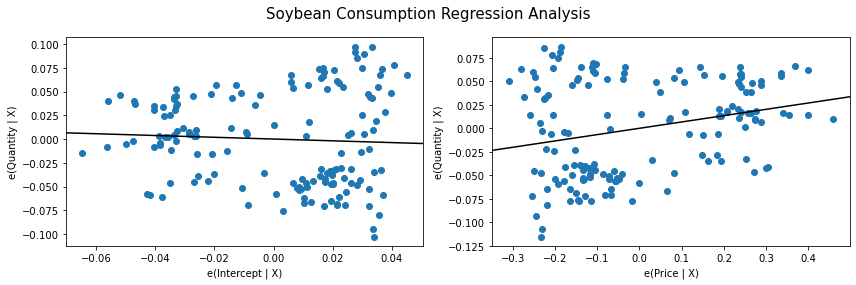

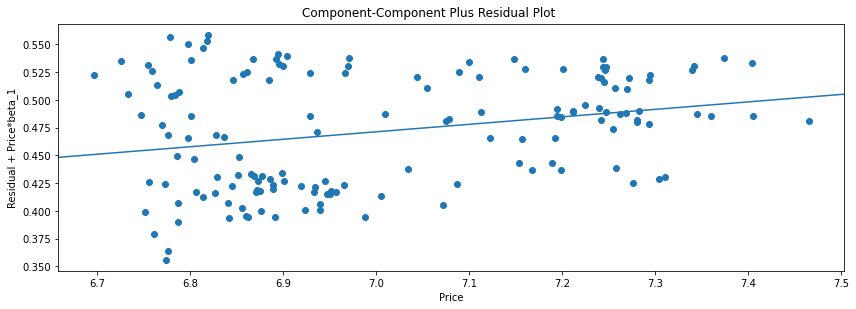

In [60]:
demand_elasticity_model(df_consumption, df_prices, 'Soybean')

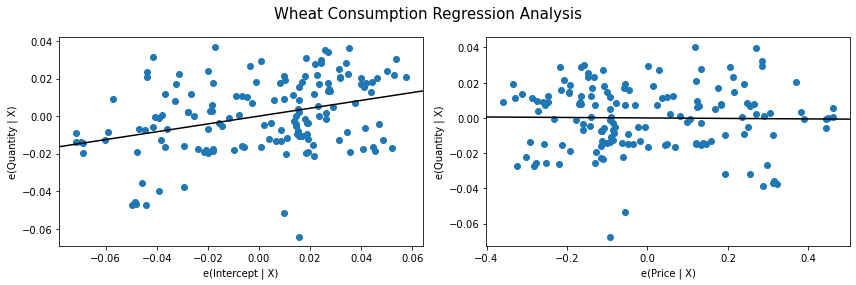

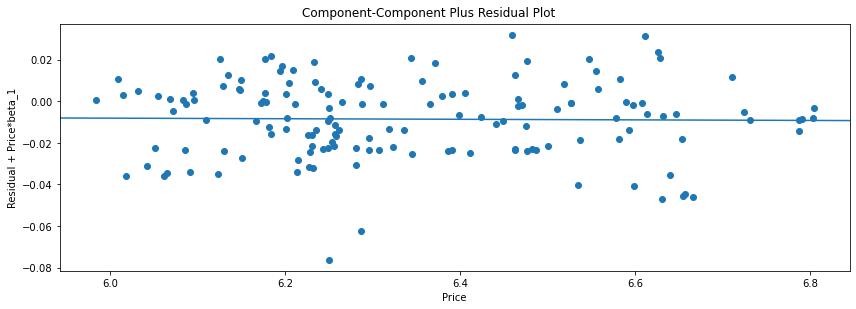

In [61]:
demand_elasticity_model(df_consumption, df_prices, 'Wheat')

Based on the above analysis, the demand for these crops appers to be inelastic to price levels. This conclusion can is drawn from the flat relationship between prices and consumption levels. This matches the findings from Yale University's study on price elasticity of food (5). 

Given the above findings, demand is forecasted based on a historical exponential moving average. 

In [62]:
def forecast_demand(df_consumption, label):
    '''
    Return a forecast for demand based on historical consumption patterns
    '''
    df = pd.pivot_table(df_consumption,index=df_consumption.index.month,columns=df_consumption.index.year,
               values=label,aggfunc=np.sum).T
    df= df.ewm(com=0.5, adjust=True).mean()
    
    forecast = pd.DataFrame(columns = ['Adj. EMW', 'EMW Forecast', 'Actual'], index = df_consumption.loc['2016':].index)
    forecast['Actual'] = df_consumption.loc['2016':, label]
    forecast['EMW Forecast'] = df_consumption.loc['2016':, label].ewm(com=0.5, adjust=True).mean().shift(1)
    forecast_list = []
    
    # iterating for each year
    for y in range(2016, 2023):
        
        # iterating for each month
        for m in range(1, 13):
            
            # mask to store values
            sample = [df.loc[y-1, m]]
            
            # same FY data
            if m != 1:
                Y_prev_months = list(df.loc[y, list(range(1,m-1))].values)
                Y_prev_months.reverse()
                sample.extend(Y_prev_months)
            
            # previous FY data
            if m != 12:
                prev_year = list(df.loc[y-1, list(range(m,13))].values)
                prev_year.reverse()
                sample.extend(prev_year)
            
            sample.reverse()
            # Storing values in a dataframe
            a = pd.DataFrame(sample, columns = ['col']).ewm(com=0.5, adjust=True).mean()
            
            forecast_list.append(a.loc[a.index[-1], 'col'])
    
    forecast_list = forecast_list[:75]
    forecast['Adj. EMW'] = forecast_list
    forecast['Adj. Forecast'] = (forecast['Adj. EMW']+forecast['EMW Forecast'])/2
    
    return forecast

The below is another method used to attempt to forecast demand. Ultimately, its results were not used in the model

In [63]:
def demand_forecast_skl(df_consumption, label, output = False, plot = False):
    '''
    Return a demand forecast df
    '''
    
    # data preparation
    df = pd.DataFrame(columns = ['consumption','shift_consumption', '4mo_avg'])
    df['consumption'] = df_consumption[label]
    df['shift_consumption'] = df_consumption[label].shift(1)
    df['4mo_avg'] = df_consumption.loc[:, label].rolling(4).mean()
    df.dropna(inplace=True)
    
    # split btw test and df
    test = df.loc[:'2016']
    df = df.loc['2017':]
    
    X = df.drop('consumption', axis=1)
    y = df['consumption']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = svm.SVR(C=1, kernel='linear', degree=8, gamma='scale', coef0=10)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    df_predictions = pd.DataFrame()
    df_predictions['predictions'] = predictions
    
    if plot:
        df_predictions.plot();
    
    # Output
    if output:
        print('=== OUTPUT ===')
        print(f'Model fit results:\n'
          f'r2_score {r2_score(y_test, predictions)} \t MSE {mean_squared_error(y_test, predictions)}'
          f'\tEVS {explained_variance_score(y_test, predictions)} \n MAE {mean_absolute_error(y_test, predictions)}'
          f'\tMAD {median_absolute_error(y_test, predictions)}\t ME {max_error(y_test, predictions)}')
    
    predictions = clf.predict(test.drop('4mo_avg', axis=1))
    
    if output:
        print('=== OUTPUT #2 ===')
        print(f'Model test results:\n'
          f'r2_score {r2_score(test["4mo_avg"], predictions)} \t MSE {mean_squared_error(test["4mo_avg"], predictions)}'
          f'\tEVS {explained_variance_score(test["4mo_avg"], predictions)} \n MAE {mean_absolute_error(test["4mo_avg"], predictions)}'
          f'\tMAD {median_absolute_error(test["4mo_avg"], predictions)}\t ME {max_error(test["4mo_avg"], predictions)}')

    df_predictions = pd.DataFrame()
    df_predictions['predictions'] = predictions
    if plot:
        df_predictions.plot();
    
    return df_predictions

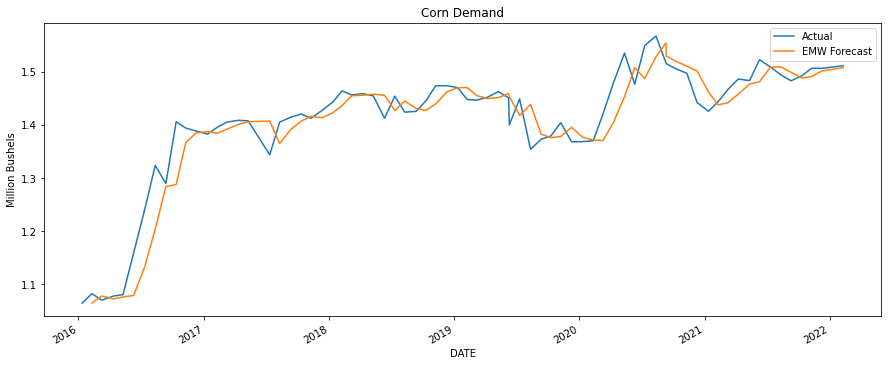

In [64]:
a = forecast_demand(df_consumption, 'Corn')
columns = ['Actual', 'EMW Forecast']
(a[columns]/10e6).plot(figsize = (15,6), title = 'Corn Demand', ylabel = 'Million Bushels');

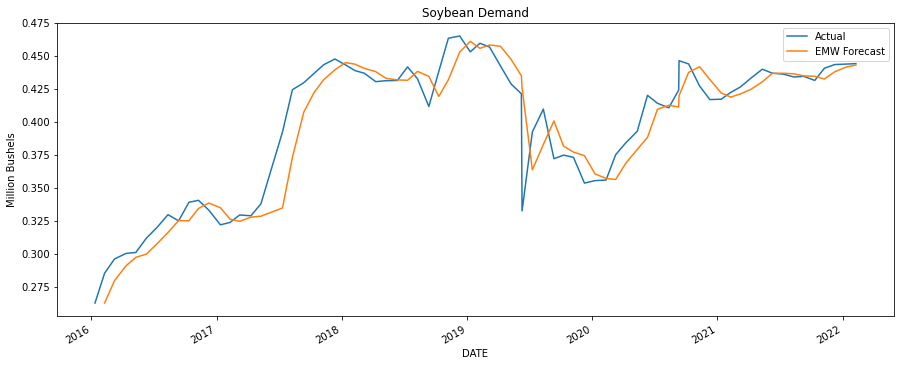

In [65]:
a = forecast_demand(df_consumption, 'Soybean')
columns = ['Actual', 'EMW Forecast']
(a[columns]/10e6).plot(figsize = (15,6), title = 'Soybean Demand', ylabel = 'Million Bushels');

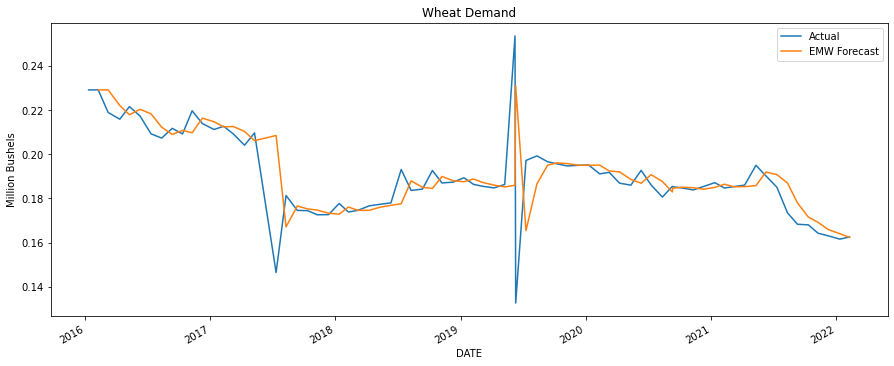

In [66]:
a = forecast_demand(df_consumption, 'Wheat')
columns = ['Actual', 'EMW Forecast']
(a[columns]/10e6).plot(figsize = (15,6), title = 'Wheat Demand', ylabel = 'Million Bushels');

In [67]:
# df_demand
df_demand = pd.DataFrame(columns = ['Corn', 'Soybean', 'Wheat'])
df_demand['Corn'] =  forecast_demand(df_consumption, 'Corn')['EMW Forecast']
df_demand['Soybean'] = forecast_demand(df_consumption, 'Soybean')['EMW Forecast']
df_demand['Wheat'] = forecast_demand(df_consumption, 'Wheat')['EMW Forecast']

## 6. Equilibrium Price Forecast

First attempt of forecasting Equilibrium price applying Bayesian Linear Regression model.

In [68]:
def price_forecast_bayesian(df_prices, df_prod_forecast, df_demand, df_consumption, label):
    
    df = pd.DataFrame()
    col = [i for i in df_prod.columns if label in i]
    df['Price'] = np.log(df_prices[label])
    df['Demand_pred'] = np.log(df_demand[label])
    df['Demand_act'] = df_consumption[label]
    df['Production_pred'] = df_prod[col[2]]
    df['Production_act'] = df_prod[col[0]]
    df.dropna(inplace = True)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df, df['Price'],test_size = 0.25,random_state = 42)
    
    import pymc3 as pm
    from pymc3 import traceplot
    
    formula = 'Price ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
    print(formula)
    
    # Context for the model
    with pm.Model() as normal_model:

        # The prior for the model parameters will be a normal distribution
        family = pm.glm.families.Normal()
        # Creating the model requires a formula and data (and optionally a family)
        pm.GLM.from_formula(formula, data = X_train, family = family)
        # Perform Markov Chain Monte Carlo sampling
        normal_trace = pm.sample(draws=2000, chains = 2, tune = 500)
    
    
    pm.plot_posterior(normal_trace)
    
    # Define a function to calculate MAE and RMSE
    def evaluate_prediction(prediction, true):
        mae = np.mean(abs(predictions - true))
        rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
        return mae, rmse
    
    median_pred = X_train['Price'].median()
    median_preds = [median_pred for _ in range(len(X_test))]
    true = X_test['Price']
    # Display mae and rmse
    mae, rmse = evaluate_prediction(median_preds, true)
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    
    return median_preds

The relatively small sample size of the OOS results featured a deeply negative $R^2$. As a result, the strategy opts for an alternate model using an expanding multivariate OLS regression model to forecast prices one period out.

In [69]:
def price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, label, log = False, x2_term = False,
                       plot = False):
    
    # Creating the DataFrame
    df = pd.DataFrame(columns = ['Price', 'Production', 'Demand'], index = df_prices.index)
    
    if log:
        df['Price'] = df_prices[label]
        df['Production'] = np.log(df_prod_forecast[label])
        df['Demand'] = np.log(df_demand[label])
    else:
        df['Price'] = df_prices[label]
        df['Production'] = df_prod_forecast[label]
        df['Demand'] = df_demand[label]
    
    # filling in demand nan with actual data for the training period
    df['Demand'].fillna(df_consumption[label], inplace = True)
    # df.dropna(inplace = True)
    
    if x2_term:
        df['Production^2'] = df['Production']**2
        df['Demand^2'] = df['Demand']**2
        
    # rolling OLS model construction
    endog = df['Price']
    exog_vars = df.columns[1:]
    exog = sm.add_constant(df[exog_vars])
    # rols = RollingOLS(endog, exog, window=len(df), min_nobs=12, expanding=True)
    rols = RollingOLS(endog, exog, window=20, min_nobs=12, expanding=True)
    rres = rols.fit()
    params = rres.params.copy()
    if plot:
        fig = rres.plot_recursive_coefficient(variables=exog_vars, figsize=(14, 18))
    
    output = pd.DataFrame(columns = ['Actual', 'Forecast'], index = params.index)
    output['Actual'] = df_prices.loc[output.index, label]
    output['Forecast'] = params.loc[output.index, 'const'] + (params.loc[output.index, exog_vars]*
                                                              df.loc[output.index, exog_vars]).sum(axis = 1)
    
    output['Forecast'] = output['Forecast'].shift(1)
    
    return output

In [70]:
# df_price_forecasts

df_price_forecasts = pd.DataFrame()

# Corn
df_price_forecasts['Corn_First_act'] =  price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, 'Corn', x2_term = True, log = True)['Actual']
df_price_forecasts['Corn_First_pred'] =  price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, 'Corn', x2_term = True, log = True)['Forecast']
df_price_forecasts['Corn_Second_act'] =  price_forecast_OLS(df_prices2, df_prod_forecast, df_demand, df_consumption, 'Corn', x2_term = True, log = True)['Actual']
df_price_forecasts['Corn_Second_pred'] =  price_forecast_OLS(df_prices2, df_prod_forecast, df_demand, df_consumption, 'Corn', x2_term = True, log = True)['Forecast']

# Soybean
df_price_forecasts['Soybean_First_act'] =  price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, 'Soybean', x2_term = True, log = True)['Actual']
df_price_forecasts['Soybean_First_pred'] =  price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, 'Soybean', x2_term = True, log = True)['Forecast']
df_price_forecasts['Soybean_Second_act'] =  price_forecast_OLS(df_prices2, df_prod_forecast, df_demand, df_consumption, 'Soybean', x2_term = True, log = True)['Actual']
df_price_forecasts['Soybean_Second_pred'] =  price_forecast_OLS(df_prices2, df_prod_forecast, df_demand, df_consumption, 'Soybean', x2_term = True, log = True)['Forecast']

# Wheat
df_price_forecasts['Wheat_First_act'] =  price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, 'Wheat', x2_term = True, log = True)['Actual']
df_price_forecasts['Wheat_First_pred'] =  price_forecast_OLS(df_prices, df_prod_forecast, df_demand, df_consumption, 'Wheat', x2_term = True, log = True)['Forecast']
df_price_forecasts['Wheat_Second_act'] =  price_forecast_OLS(df_prices2, df_prod_forecast, df_demand, df_consumption, 'Wheat', x2_term = True, log = True)['Actual']
df_price_forecasts['Wheat_Second_pred'] =  price_forecast_OLS(df_prices2, df_prod_forecast, df_demand, df_consumption, 'Wheat', x2_term = True, log = True)['Forecast']

df_price_forecasts.dropna(inplace = True)

In [71]:
def plot_price_forecast(df_price_forecasts, label):
    '''
    Shows the plot of actual commodities prices vs developed forecasts
    '''
    columns = [label+'_First_act', label+'_First_pred', label+'_Second_act', label+'_Second_pred']
        
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,6), sharex=True)
    
    # Front of the month contract
    ax1.plot(df_price_forecasts.loc[:,columns[0]], color ='tab:blue', label = 'Front Month Actual')
    ax1.plot(df_price_forecasts.loc[:,columns[1]], color ='tab:orange', label = 'Front Month Forecast')
    ax1.legend()
    ax1.set_ylabel('Price ($USD)')
    
    ax2.plot(df_price_forecasts.loc[:,columns[2]], color ='tab:red', label = 'End Month Actual')
    ax2.plot(df_price_forecasts.loc[:,columns[3]], color ='tab:green', label = 'End Month Forecast')
    ax2.set_ylabel('Price ($USD)')
    ax2.legend()
    ax2.set_xlabel('Date')
    fig.suptitle(label+' Price Level:  Actual VS Forecast', size = 15)
    plt.show();

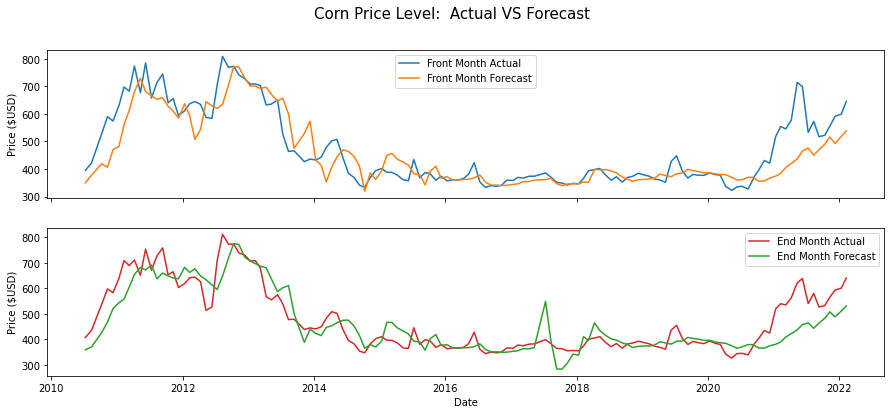

In [72]:
plot_price_forecast(df_price_forecasts, 'Corn')

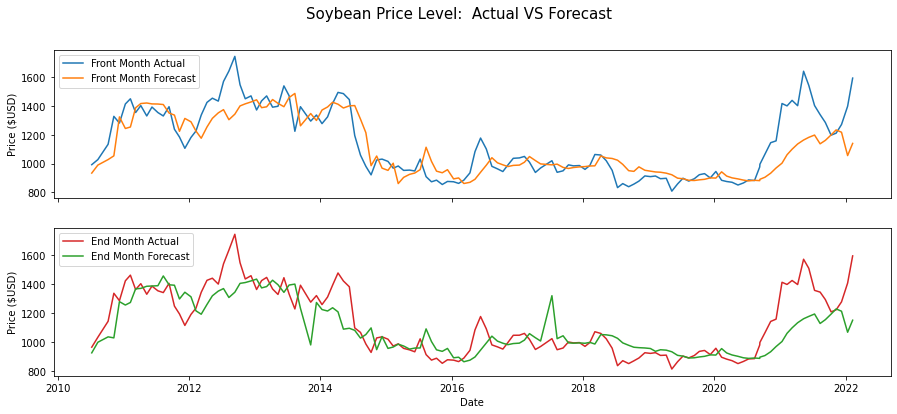

In [73]:
plot_price_forecast(df_price_forecasts, 'Soybean')

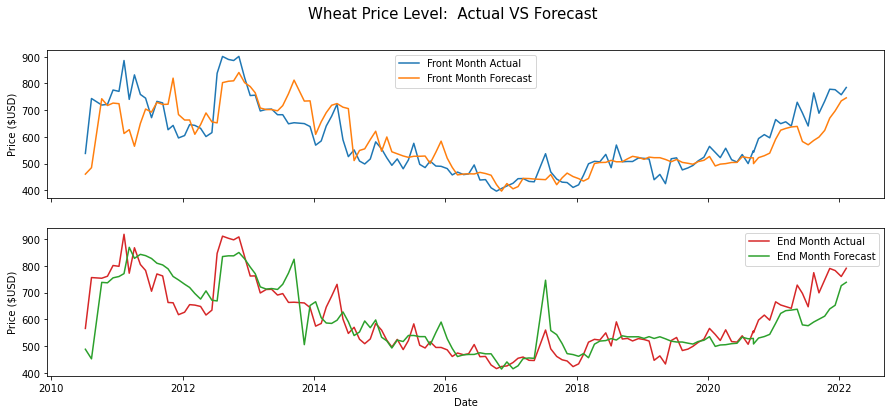

In [74]:
plot_price_forecast(df_price_forecasts, 'Wheat')

## Create and Backtest Trading Strategy

###### Create index of trading day from prices

In [75]:
# Create Dataframe of indexes from prices
index_full = corn_futures_first.merge(corn_futures_second, how= 'outer', left_index = True, right_index = True)
for i in [soybean_futures_first,soybean_futures_second,wheat_futures_first,wheat_futures_second]:
    index_full = index_full.merge(i, how= 'outer', left_index = True, right_index = True)

index_full = index_full.index

### Backtester

###### Setup Prices DataFrame

In [76]:
# Assign Open and Close Prices
prices = pd.DataFrame(index = index_full)

prices['Corn-F Open'] = corn_futures_first['open']
prices['Corn-F Close'] = corn_futures_first['settle']
prices['Corn-F Prev Vol'] = corn_futures_first['volume']

prices['Corn-B Open'] = corn_futures_second['open']
prices['Corn-B Close'] = corn_futures_second['settle']
prices['Corn-B Prev Vol'] = corn_futures_second['volume']

prices['Soy-F Open'] = soybean_futures_first['open']
prices['Soy-F Close'] = soybean_futures_first['settle']
prices['Soy-F Prev Vol'] = soybean_futures_first['volume']

prices['Soy-B Open'] = soybean_futures_second['open']
prices['Soy-B Close'] = soybean_futures_second['settle']
prices['Soy-B Prev Vol'] = soybean_futures_second['volume']

prices['Wheat-F Open'] = wheat_futures_first['open']
prices['Wheat-F Close'] = wheat_futures_first['settle']
prices['Wheat-F Prev Vol'] = wheat_futures_first['volume']

prices['Wheat-B Open'] = wheat_futures_second['open']
prices['Wheat-B Close'] = wheat_futures_second['settle']
prices['Wheat-B Prev Vol'] = wheat_futures_second['volume']

prices.sort_index(inplace = True)

###### Create monthy volatility bands and moving average of volume to inform position sizing  

Assuming normality, thresholds are created at the following confidence intervals:  

**68%** - 1 standard deviation  
**90%** - 1.645 standard deviations

This creates three areas on each side of the close price (for a total of 6 areas) where position sizes can be assigned according the predicted price.  

20 days is used because this is the approximate number of trading days between monthly reports

In [77]:
# Get standard deviations
prices['Corn-F 20 Std'] = prices['Corn-F Close'].shift(1).rolling(20).std()
prices['Soy-F 20 Std'] = prices['Soy-F Close'].shift(1).rolling(20).std()
prices['Wheat-F 20 Std'] = prices['Wheat-F Close'].shift(1).rolling(20).std()

prices['Corn-B 20 Std'] = prices['Corn-B Close'].shift(1).rolling(20).std()
prices['Soy-B 20 Std'] = prices['Soy-B Close'].shift(1).rolling(20).std()
prices['Wheat-B 20 Std'] = prices['Wheat-B Close'].shift(1).rolling(20).std()

# Create Moving averages for volume
prices['Corn-F Vol MA'] = prices['Corn-F Prev Vol'].shift(1).rolling(20).mean()
prices['Soy-F Vol MA'] = prices['Soy-F Prev Vol'].shift(1).rolling(20).mean()
prices['Wheat-F Vol MA'] = prices['Wheat-F Prev Vol'].shift(1).rolling(20).mean()

prices['Corn-B Vol MA'] = prices['Corn-B Prev Vol'].shift(1).rolling(20).mean()
prices['Soy-B Vol MA'] = prices['Soy-B Prev Vol'].shift(1).rolling(20).mean()
prices['Wheat-B Vol MA'] = prices['Wheat-B Prev Vol'].shift(1).rolling(20).mean()

###### The below function assigns a trading signal from a predicted price using the guidelines above

In [78]:
# Function to apply position sizes / labels for trading
def position_label(x, sizes = [1.645,1,-1,-1.645]):
    if x > sizes[0]:
        return 3
    elif x > sizes[1]:
        return 2
    elif x > 0:
        return 1
    elif x > sizes[2]:
        return -1
    elif x > sizes[3]:
        return -2
    else:
        return -3

###### Establish Positions  

Use the predicted prices with the bands created in the previous step to determine what position to take.  

Position sizes are limited to 1% of volume, determined by the monthly rolling average of the volume

In [79]:
positions = pd.DataFrame(index = index_full)

# Determine report dates
report_date= lambda x: x in df_price_forecasts.index
reports = [report_date(i) for i in positions.index]
positions['report date'] =  reports

# Assign position sizes to take on the report dates
for i in range(0, len(positions)):
    ix = positions.index.values[i]
    
    # get Z scores of each predicted price against the monthly volatilities for each contract
    if positions.loc[ix,'report date'] == True:
        # Standardize price difference between predicted and actual
        Corn_F_Z = (df_price_forecasts.loc[ix,'Corn_First_pred'] - prices.loc[ix,'Corn-F Close']) / prices.loc[ix,'Corn-F 20 Std']
        Corn_B_Z = (df_price_forecasts.loc[ix,'Corn_Second_pred'] - prices.loc[ix,'Corn-B Close']) / prices.loc[ix,'Corn-B 20 Std']
        
        Soy_F_Z = (df_price_forecasts.loc[ix,'Soybean_First_pred'] - prices.loc[ix,'Soy-F Close']) / prices.loc[ix,'Soy-F 20 Std']
        Soy_B_Z = (df_price_forecasts.loc[ix,'Soybean_Second_pred'] - prices.loc[ix,'Soy-B Close']) / prices.loc[ix,'Soy-B 20 Std']
    
        Wheat_F_Z = (df_price_forecasts.loc[ix,'Wheat_First_pred'] - prices.loc[ix,'Wheat-F Close']) / prices.loc[ix,'Wheat-F 20 Std']
        Wheat_B_Z = (df_price_forecasts.loc[ix,'Wheat_Second_pred'] - prices.loc[ix,'Wheat-B Close']) / prices.loc[ix,'Wheat-B 20 Std']
        
        # Generate trading signal
        positions.loc[ix,'Corn-F Signal'] =  position_label(Corn_F_Z)
        positions.loc[ix,'Corn-B Signal'] =  position_label(Corn_B_Z)
        
        positions.loc[ix,'Soy-F Signal'] =  position_label(Soy_F_Z)
        positions.loc[ix,'Soy-B Signal'] =  position_label(Soy_B_Z)
        
        positions.loc[ix,'Wheat-F Signal'] =  position_label(Wheat_F_Z)
        positions.loc[ix,'Wheat-B Signal'] =  position_label(Wheat_B_Z)
        
        # Establish position size from trading signal
        for contract in ['Corn-F','Corn-B','Soy-F','Soy-B','Wheat-F','Wheat-B']:
            signal = contract + ' Signal'
            vol = contract + ' Vol MA'
            pos = contract + ' Pos'
            if  positions.loc[ix,signal] == 3:
                 positions.loc[ix,pos] = round(.01 * prices.loc[ix,vol],0)
            elif  positions.loc[ix,signal] == 2:
                 positions.loc[ix,pos] = round(.005 * prices.loc[ix,vol],0)
            elif  positions.loc[ix,signal] == 1:
                 positions.loc[ix,pos] = round(.001 * prices.loc[ix,vol],0)
            elif  positions.loc[ix,signal] == -1:
                 positions.loc[ix,pos] = round(-.001 * prices.loc[ix,vol],0)
            elif  positions.loc[ix,signal] == -2:
                 positions.loc[ix,pos] = round(-.005 * prices.loc[ix,vol],0)
            elif  positions.loc[ix,signal] == -3:
                 positions.loc[ix,pos] = round(-.01 * prices.loc[ix,vol],0)

# The positions are carried for the month and filled as such
positions['Corn-F Pos'].fillna(method='bfill', inplace = True)
positions['Corn-B Pos'].fillna(method='bfill', inplace = True)
positions['Soy-F Pos'].fillna(method='bfill', inplace = True)
positions['Soy-B Pos'].fillna(method='bfill', inplace = True)
positions['Wheat-F Pos'].fillna(method='bfill', inplace = True)
positions['Wheat-B Pos'].fillna(method='bfill', inplace = True)

positions['Corn-F Pos'].fillna(0, inplace = True)
positions['Corn-B Pos'].fillna(0, inplace = True)
positions['Soy-F Pos'].fillna(0, inplace = True)
positions['Soy-B Pos'].fillna(0, inplace = True)
positions['Wheat-F Pos'].fillna(0, inplace = True)
positions['Wheat-B Pos'].fillna(0, inplace = True)


**Note** - the first trading day of the strategy is 2010-07-09. The dataframe initializes one day prior with 0 balances and the remaining dates are cut off.

In [80]:
col_to_keep = ['report date','Corn-F Pos', 'Corn-B Pos', 'Soy-F Pos', 'Soy-B Pos', 'Wheat-F Pos', 'Wheat-B Pos']
positions = positions.loc[:'2010-07-08', col_to_keep]

In [81]:
positions.sort_index(inplace = True)
positions

,report date,Corn-F Pos,Corn-B Pos,Soy-F Pos,Soy-B Pos,Wheat-F Pos,Wheat-B Pos
date,,,,,,,
2010-07-08,False,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-09,True,-1033.0,-196.0,-431.0,-108.0,-497.0,-224.0
2010-07-12,False,-1033.0,-196.0,-431.0,-108.0,-497.0,-224.0
2010-07-13,False,-1033.0,-196.0,-431.0,-108.0,-497.0,-224.0
2010-07-14,False,-1033.0,-196.0,-431.0,-108.0,-497.0,-224.0
...,...,...,...,...,...,...,...
2022-02-04,False,-1148.0,-353.0,-918.0,-238.0,-208.0,-119.0
2022-02-07,False,-1148.0,-353.0,-918.0,-238.0,-208.0,-119.0
2022-02-08,False,-1148.0,-353.0,-918.0,-238.0,-208.0,-119.0


### Borrowing Costs and Starting Captial  

The traded front and back month traded contracts recorded the following volumes on 2/25/2022   

**Volumes**  
**ZC** - 346K / 160K  
**ZS** - 234K / 87K  
**ZW** - 112K / 67K  

Given the front/back month margin requirement on 2/25/2022

**Margin Requirements (Front/Back)**  
**ZC** - \\$2350 / \\$2200  
**ZS** - \\$3750 / \\$3700  
**ZW** - \\$5100 / \\$5000   

Based on the volumes and margin requirements, the strategy would require **~\\$33m** in margin at maximum position size (one percent of daily volumes). To meet this requirement, the strategy starts with **\\$50m** in capital and leverages up to 2x.  

Leveraged capital accrues interest at an annual rate of 0.8% (IB benchmark).  

**Slippage**  
Observation of real-time trading books (circa 2016/2017) for the 3 products informs the assumptions of slippage. It was observed that at prices "near" the top of the book, quantities range from approximately 50-150 contracts per price. As such, a market sweep at an **average price** of the best price plus 3 ticks (top of the book plus the next six prices) allows for 350-1050 contracts. This assumption is reasonably conservative given the volumes listed above.


### Stop Loss
Since CME margin requirements are calculated from volatility, the trading strategy sets a stop loss in the case that losses exceed 50% of the portfolio margin requirement.  

**Note** - this strategy uses a constant set of margin requirements. In reality, these requirements are updated daily. An improvement to this strategy is would be to apply the actualy historical margin requirements to the back test

### Trading Mechanics  
**Trading Dates**  
The strategy rebalances on dates when a USDA crop production report is scheduled to be released  


**Entering Positions**  
Positions are entered on report release days after the release at the closing price plus 3 ticks  

**Exiting Positions**  
Positions are exited on report release days prior to the release at the opening price plus 3 ticks  

**Note** - as futures are traded overnight, open and close prices are defined as the Chicago 8:30am open and 1:20pm close

In [82]:
# Portfolio 
portfolio = pd.DataFrame(index = positions.index)

# Starting Capital
portfolio['Capital'] = 50000000

# Borrowing rate
borrow_rate = 0.08 / 365

# Calculate Margin Requirement
portfolio['Margin Requirement'] = \
    (abs(positions['Corn-F Pos']).shift() * 2350) +\
    (abs(positions['Soy-F Pos']).shift() * 3750) +\
    (abs(positions['Wheat-F Pos']).shift() * 5100) +\
    (abs(positions['Corn-B Pos']).shift() * 2200) +\
    (abs(positions['Soy-B Pos']).shift() * 3700) +\
    (abs(positions['Wheat-B Pos']).shift() * 5000)

# Calcualte borrowing amount
portfolio['Borrow Amount'] = np.where(portfolio['Margin Requirement'] - portfolio['Capital'] > 0,
                                      portfolio['Margin Requirement'] - portfolio['Capital'] ,0)

# Calculate portfolio leverage
portfolio['Leverage'] = (portfolio['Capital'] + portfolio['Borrow Amount']) / portfolio['Capital']

# Calculate daily interest
portfolio['Interest'] = borrow_rate * portfolio['Borrow Amount']

# Caclulate comissions applied at $0.51 per side (closing old, and opening new contracts)
portfolio['Comissions Costs'] = np.where(portfolio.index.isin(df_price_forecasts.index),
                                         (abs(positions['Corn-F Pos']) + abs(positions['Soy-F Pos']) + abs(positions['Wheat-F Pos']) + \
                                         abs(positions['Corn-B Pos']) + abs(positions['Soy-B Pos']) + abs(positions['Wheat-B Pos']) + \
                                         abs(positions['Corn-F Pos'].shift()) + abs(positions['Soy-F Pos'].shift()) + abs(positions['Wheat-F Pos'].shift()) + \
                                         abs(positions['Corn-B Pos'].shift()) + abs(positions['Soy-B Pos'].shift()) + abs(positions['Wheat-B Pos'].shift())) * 0.51 ,
                                         0)

# Slippage applied at 3 ticks (3 ticks x $12.5/tick = $37.5) per contract
portfolio['Slippage'] = np.where(portfolio.index.isin(df_price_forecasts.index),
                                         (abs(positions['Corn-F Pos']) + abs(positions['Soy-F Pos']) + abs(positions['Wheat-F Pos']) + \
                                         abs(positions['Corn-B Pos']) + abs(positions['Soy-B Pos']) + abs(positions['Wheat-B Pos']) + \
                                         abs(positions['Corn-F Pos'].shift()) + abs(positions['Soy-F Pos'].shift()) + abs(positions['Wheat-F Pos'].shift()) + \
                                         abs(positions['Corn-B Pos'].shift()) + abs(positions['Soy-B Pos'].shift()) + abs(positions['Wheat-B Pos'].shift())) * 37.5 ,
                                         0)



# PnL Measures
portfolio['Daily PnL'] = 0
portfolio['Unrealized PnL'] = 0 
portfolio['Realized PnL'] = 0 
portfolio['Costs'] = portfolio['Comissions Costs'] + portfolio['Interest'] + portfolio['Slippage']
portfolio['Cumulative Costs'] = portfolio['Costs'].cumsum()
portfolio['Cumulative PnL'] = 0

# implement a stop loss
stop = False

# Run strategy
for i in range(2, len(positions)):
    ix = positions.index.values[i]
    ix2 = positions.index.values[i-1]

    portfolio.loc[ix,'stop'] = stop
    
    # Case: Stopped
    # Case: Report Date
    if positions.loc[ix,'report date'] == True:
        
        # Get PnL from closing the positions
        close_pnl = positions.loc[ix,'Corn-F Pos'] * 12.5 *(prices.loc[ix,'Corn-F Open'] - prices.loc[ix2,'Corn-F Close']) + \
            positions.loc[ix2,'Corn-F Pos'] * 12.5 * (prices.loc[ix,'Corn-F Open'] - prices.loc[ix2,'Corn-F Close']) + \
            positions.loc[ix2,'Corn-B Pos'] * 12.5 * (prices.loc[ix,'Corn-B Open'] - prices.loc[ix2,'Corn-B Close']) + \
            positions.loc[ix2,'Soy-F Pos'] * 12.5 * (prices.loc[ix,'Soy-F Open'] - prices.loc[ix2,'Soy-F Close']) + \
            positions.loc[ix2,'Soy-B Pos'] * 12.5 * (prices.loc[ix,'Soy-B Open'] - prices.loc[ix2,'Soy-B Close']) + \
            positions.loc[ix2,'Wheat-F Pos'] * 12.5 * (prices.loc[ix,'Wheat-F Open'] - prices.loc[ix2,'Wheat-F Close']) + \
            positions.loc[ix2,'Wheat-B Pos'] * 12.5 * (prices.loc[ix,'Wheat-B Open'] - prices.loc[ix2,'Wheat-B Close'])
        
        portfolio.loc[ix,'Unrealized PnL'] += close_pnl
        portfolio.loc[ix,'Realized PnL'] += portfolio.loc[ix,'Unrealized PnL']
        portfolio.loc[ix,'Unrealized PnL'] = 0
        stop = False
        
    #Case: Stopped
    elif stop == True:
        # Update PnL
        portfolio.loc[ix,'Daily PnL'] = 0
        portfolio.loc[ix,'Realized PnL'] = portfolio.loc[ix2,'Realized PnL']
        portfolio.loc[ix,'Unrealized PnL'] = 0
        
    # Case: Default
    else:
        
        # Update daily PnL
        portfolio.loc[ix,'Daily PnL'] = positions.loc[ix,'Corn-F Pos'] * 12.5 * (prices.loc[ix,'Corn-F Close'] - prices.loc[ix2,'Corn-F Close']) + \
            positions.loc[ix,'Corn-F Pos'] * 12.5 * (prices.loc[ix,'Corn-F Close'] - prices.loc[ix2,'Corn-F Close']) + \
            positions.loc[ix,'Corn-B Pos'] * 12.5 * (prices.loc[ix,'Corn-B Close'] - prices.loc[ix2,'Corn-B Close']) + \
            positions.loc[ix,'Soy-F Pos'] * 12.5 * (prices.loc[ix,'Soy-F Close'] - prices.loc[ix2,'Soy-F Close']) + \
            positions.loc[ix,'Soy-B Pos'] * 12.5 * (prices.loc[ix,'Soy-B Close'] - prices.loc[ix2,'Soy-B Close']) + \
            positions.loc[ix,'Wheat-F Pos'] * 12.5 * (prices.loc[ix,'Wheat-F Close'] - prices.loc[ix2,'Wheat-F Close']) + \
            positions.loc[ix,'Wheat-B Pos'] * 12.5 * (prices.loc[ix,'Wheat-B Close'] - prices.loc[ix2,'Wheat-B Close'])

        # Update  PnL
        portfolio.loc[ix,'Realized PnL'] = portfolio.loc[ix2,'Realized PnL']
        portfolio.loc[ix,'Unrealized PnL'] = portfolio.loc[ix2,'Unrealized PnL'] + portfolio.loc[ix,'Daily PnL']
        
        # stop out if losses exceed half of the margin requirement
        if -portfolio.loc[ix,'Unrealized PnL'] > portfolio.loc[ix,'Margin Requirement'] * 0.5:
            stop = True
            
            # close positions
            portfolio.loc[ix,'Realized PnL'] += portfolio.loc[ix,'Unrealized PnL']
            portfolio.loc[ix,'Unrealized PnL'] = 0
        
portfolio['Cumulative PnL'] = portfolio['Realized PnL'] + portfolio['Unrealized PnL'] - portfolio['Cumulative Costs']
portfolio['Cumulative PnL (G)'] = portfolio['Realized PnL'] + portfolio['Unrealized PnL']
portfolio['Capital'] = 50000000 + portfolio['Cumulative PnL']
portfolio['Capital (G)'] = 50000000 + portfolio['Cumulative PnL (G)']

portfolio['Return'] = (portfolio['Capital'] / portfolio['Capital'].shift())-1
portfolio['Return (G)'] = (portfolio['Capital (G)'] / portfolio['Capital (G)'].shift())-1
        
portfolio['Interest Cumulative'] = portfolio['Interest'].cumsum()
portfolio['Comissions Costs Cumulative'] = portfolio['Comissions Costs'].cumsum()
portfolio['Slippage Cumulative'] = portfolio['Slippage'].cumsum()
        

In [83]:
portfolio.head()

,Capital,Margin Requirement,Borrow Amount,Leverage,Interest,Comissions Costs,Slippage,Daily PnL,Unrealized PnL,Realized PnL,...,Cumulative Costs,Cumulative PnL,stop,Cumulative PnL (G),Capital (G),Return,Return (G),Interest Cumulative,Comissions Costs Cumulative,Slippage Cumulative
date,,,,,,,,,,,,,,,,,,,,,
2010-07-08,5.000000e+07,NaN,0.0,1.0,0.0,0.00,0.0,0.000,0.000,0.0,...,0.00,0.000,NaN,0.000,5.000000e+07,NaN,NaN,0.0,0.00,0.0
2010-07-09,4.990539e+07,0.0,0.0,1.0,0.0,1269.39,93337.5,0.000,0.000,0.0,...,94606.89,-94606.890,NaN,0.000,5.000000e+07,-0.001892,0.000000,0.0,1269.39,93337.5
2010-07-12,5.000039e+07,8529300.0,0.0,1.0,0.0,0.00,0.0,94996.875,94996.875,0.0,...,94606.89,389.985,False,94996.875,5.009500e+07,0.001904,0.001900,0.0,1269.39,93337.5
2010-07-13,5.002454e+07,8529300.0,0.0,1.0,0.0,0.00,0.0,24153.125,119150.000,0.0,...,94606.89,24543.110,False,119150.000,5.011915e+07,0.000483,0.000482,0.0,1269.39,93337.5
2010-07-14,4.965105e+07,8529300.0,0.0,1.0,0.0,0.00,0.0,-373496.875,-254346.875,0.0,...,94606.89,-348953.765,False,-254346.875,4.974565e+07,-0.007466,-0.007452,0.0,1269.39,93337.5


### Plot of the cumulative profit and loss  

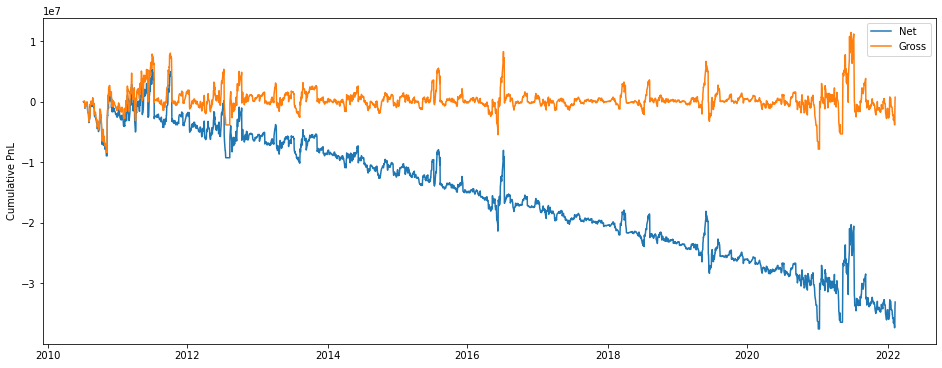

In [84]:
plt.figure(figsize=(16,6))
plt.plot(portfolio['Cumulative PnL'], label='Net')
plt.plot(portfolio['Cumulative PnL (G)'],label='Gross')

plt.ylabel('Cumulative PnL')
plt.legend()

Plotting the (gross and net) cumulative profit and loss (PnL) , the following is observed:  

- The gross cumulative PnL is centered at zero and relatively flat from a visual perspective. This may indicate a few issues with the strategy. The first, is that our predictions may have very little predictive power similar to how randomly taking long and short positions would produce a somewhat flat PnL given a 50/50 distribution. The second issue is that the strategy may not trade frequently enough to take advantage of any predictive power from the forecasts. Because the strategy trades on monthly intervals, the frequency may not be high enough to take advantage of the law of large numbers


- The net cumulative PnL adds a negative drift to the otherwise flat gross cumulative PnL. This is expected, but it is also a good visual on how trading expenses can turn an otherwise marignal (or profitable) strategy negative. An analysis of trading expenses is done below

Total Slippage: 		 33331912.5
Total Commissions: 		 453314.01000000007
Total Interest Expense: 	 0.0


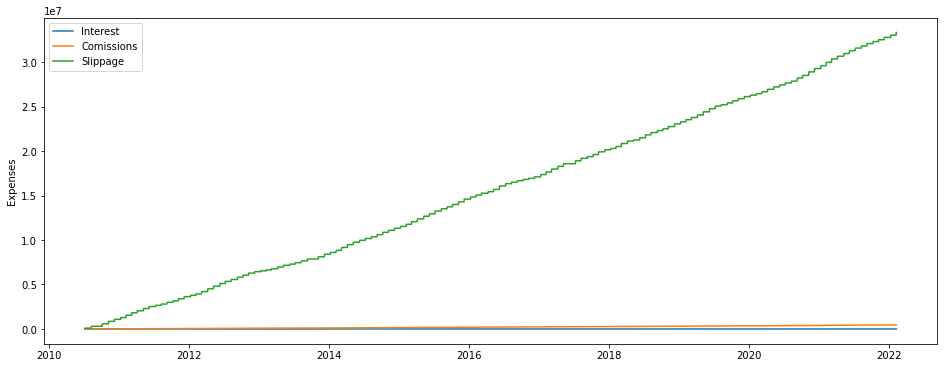

In [85]:
plt.figure(figsize=(16,6))
plt.plot(portfolio['Interest Cumulative'], label='Interest')
plt.plot(portfolio['Comissions Costs Cumulative'],label='Comissions')
plt.plot(portfolio['Slippage Cumulative'],label='Slippage')

plt.ylabel('Expenses')
plt.legend()

print('Total Slippage: \t\t',portfolio['Slippage Cumulative'][-1])
print('Total Commissions: \t\t',portfolio['Comissions Costs Cumulative'][-1])
print('Total Interest Expense: \t',portfolio['Interest Cumulative'][-1])


The conculsion from the above graph of trading expenses is that slippage contributes the most to the expenses, with over \\$30m in expenses at the end of the back test. This leaves room in the strategy to improve from an execution standpoint. The current slippage modeled in the strategy is 3 ticks on each trade per contract. Reducing slippage by an average of 1 tick per trade results in saving \\$11m in expenses. 

### Run Against Benchmarks  
**Note** - use 256 as an approximation of trading days in a year to annualize

In [86]:
# Functions for trading stats

def summary_stats(df, annual_fac=256):
    ss_df = (df.mean() * annual_fac).to_frame('Mean')
    ss_df['Vol'] = df.std() * np.sqrt(annual_fac)
    ss_df['Sharpe'] = ss_df['Mean'] / ss_df['Vol']
    
    return round(ss_df, 4)

# Tail Risk 
def tail_risk_report(data, q=0.05):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['Expected Shortfall'] = df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()

    return round(report,4)

In [87]:
all_port = portfolio[['Return','Return (G)']][1:].rename(columns = {'Return':'Strategy', 'Return (G)':'Strategy (G)'})
all_port = all_port.join(benchmark_df)

###### Basic Performance Statistics

In [88]:
summary_stats(all_port).sort_values('Sharpe', ascending = False)

,Mean,Vol,Sharpe
SPY,0.1613,0.1692,0.9536
DIA,0.1481,0.1697,0.8729
RJA,0.0318,0.1522,0.2091
Strategy (G),0.0251,0.2182,0.1152
DBA,-0.0024,0.1305,-0.0183
Strategy,-0.0114,0.4161,-0.0273
Constructed,-0.0108,0.1763,-0.0615


Observations from the above:  
    
-The Strategy performs poorly by all metrics when compared against the benchmarks. The exception to this is the constructed even-weighted portfolio of the 3 commodities that are traded.  

-The gross Strategy performs better than DBA and achieves positive returns and Sharpe ratio. However, as there are no costs associated with this strategy, this is better viewed as an index/ benchmark for our own strategy

###### Tail Risks Statistics

In [89]:
tail_risk_report(all_port)

,Strategy,Strategy (G),SPY,DIA,DBA,RJA,Constructed
Skewness,4.2968,0.1002,-0.6373,-0.6631,-0.0183,-0.1304,0.2270
Excess Kurtosis,139.3109,42.7549,14.1276,21.2180,2.9863,6.5189,2.2951
VaR,-0.0265,-0.0159,-0.0160,-0.0152,-0.0123,-0.0135,-0.0169
Expected Shortfall,-0.0561,-0.0323,-0.0260,-0.0256,-0.0182,-0.0208,-0.0237
Max Drawdown,-0.7740,-0.2762,-0.3370,-0.3669,-0.6188,-0.6152,-0.7166


The strategy has the largest drawdown of all of the portfolios. This may a result of the leveraged nature of futures contracts as DBA and RJA, indexes constructed from futures contracts, also have drawdowns in the same range as our Strategy 

In addition, the Strategy has the largest excess kurtosis and a heavy positive skew. This is most likely the result of bad price predictions from the model, which lead the strategy to assume that market mispricings are larger than they should be. As a result, the strategy takes maximum position sizes (both long and short) which can result in fat tails on the distribution of returns.

###### Correlations

MIN Correlation pair is ('RJA', 'Strategy (G)')
MAX Correlation pair is ('DIA', 'SPY')


<AxesSubplot:>

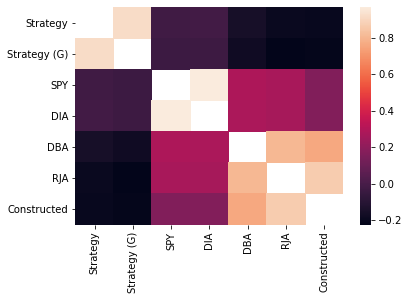

In [90]:
# Correlation Matrix 
corr_mat = round(all_port.corr(), 4)

corr_mat
corr_mat[corr_mat == 1] = None

corr_rank = corr_mat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

sns.heatmap(corr_mat)

From the heatmap above, the strategy is the least correlated with any of the other portfolios. Surprisingly, it is least correlated with the other agriculture benchmarks.

## Final Conclusions

**Trading Strategy and Benchmarks**  
The results of the trading strategy leave much to be desired by any metric when compared against the benchmarks. However, analysis of the gross and net profit and loss shows that there is much room for improvement on the execution side, which, alone, can bring the strategy to a marginally profitable status.  

The analysis of the gross cumulative profit and loss shows that the strategy has potential to be profitable as the mean return is slightly positive. In its current state, the strategy could improve in two areas:  

- Increasing predictive power - this is relatively straightforward, a revisit of the methods and techniques used to get to predicted prices may be worth the effort, as better predictions lead to better and stronger trading signals.  


- Better implementation of trading parameters - this strategy implements a very vanilla approach to position sizing and mainly focuses on establishing conservative trading cost estimates. As such, the results of this strategy can be thought of as closer to the floor, rather than the ceiling, of its range of outcomes. As the other two agricultural futures-based benchmarks have positive mean returns, this is an indication that a stronger, more thought out set of trading rules can be used to improve the returns of our strategy.

**References:**
1. Yadira Mori-Clement, Anik Bhaduri, Nodir Djanibekov - "Food price fluctuations in Uzbekistan: Evidences from local markets in 2002-2010"
2. Kuk-Hyun Ahn,Richard Palmer, Scott Steinschneider - "A hierarchical Bayesian model for regionalized seasonal forecasts: Application to low flows in the northeastern United States"
3. Bajari, Patrick, Denis Nekipelov, Stephen P. Ryan, and Miaoyu Yang. 2015. "Machine Learning Methods for Demand Estimation." American Economic Review, 105 (5): 481-85.
4. Henry Schultz: The Statistical Measurement of the Elasticity of Demand for Beef